In [1]:
import numpy as np
import matplotlib.pyplot as plt
import mdtraj as md
import os

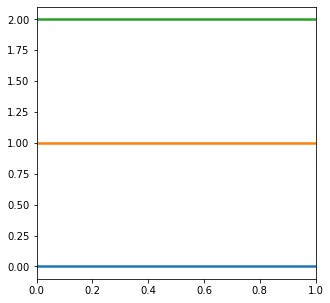

In [2]:
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

#new_cmap = ['#1F78B4','#FB9A99','#E31A1C']
new_cmap = ['tab:blue','tab:orange','tab:green']
rtg_r = LinearSegmentedColormap.from_list("rtg", new_cmap)
colors = rtg_r(np.linspace(0,1,3))

#Test colormap
fig = plt.figure(figsize=(5,5))

for i,color in enumerate(colors):
    plt.axhline(i, color=colors[i], linewidth=2.5)

In [3]:
proteins = ['ubq', 'villin_h36']
#lambdas = ['1.00', '1.10', '1.12']
rescaling_approach = ['OG', 'PW', 'PP']
lambdas_approach = {'OG':'1.00', 'PW':'1.10', 'PP':'0.88'}

Kd_exp = [4.9, 1.5]
protein_names = {'villin_h36':'villin HP36', 'ubq':'ubiquitin'}

replicas = 10

#Bound threshold
thresh = 0.8

PW_dir = '/storage1/thomasen/MARTINI_rescaling/MARTINI_PWrescaling/protein_protein/Production_run'

# Get real fraction bound based on Kd

In [4]:
real_fraction_bound_vs_protein = []
for i,protein in enumerate(proteins):
    real_fraction_bound_vs_lambda = []
    for approach in rescaling_approach:
        l=lambdas_approach[approach]
        avg_volume = 0
        for replica in range(1,replicas+1):
            if approach == 'OG' or approach == 'PW':
                volume = np.genfromtxt(f'{PW_dir}/{protein}/two_{protein}_{replica}/lambda_{l}/pVTE.xvg', skip_header=27, usecols=4, unpack=True)
                avg_volume += np.average(volume)
            elif approach == 'PP':
                volume = np.genfromtxt(f'{protein}/two_{protein}_{replica}/pVTE.xvg', skip_header=27, usecols=4, unpack=True)
                avg_volume += np.average(volume)

        avg_volume = avg_volume/replicas
        avogadros = 6.022*(10**23)
        vol_liters = avg_volume*((10**-9)**3)*(10**3)

        conc = ((2/avogadros)/vol_liters)*(10**3) #2 for two copies of the protein
        print(conc)
        real_fraction_bound = (4*conc + Kd_exp[i] - np.sqrt(8*Kd_exp[i]*conc + np.square(Kd_exp[i])))/(4*conc)

        real_fraction_bound_vs_lambda.append(real_fraction_bound)

    real_fraction_bound = np.average(real_fraction_bound_vs_lambda)
    real_fraction_bound_vs_protein.append(real_fraction_bound)

1.045750363856109
1.0460472910273424
1.0457783577927695
8.920136285132887
8.931263444575734
8.92144571049754


# Binding/unbinding with mindist between all beads

/lindorffgrp-isilon/thomasen/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
mkdir: cannot create directory ‘figures/villin_h36’: File exists


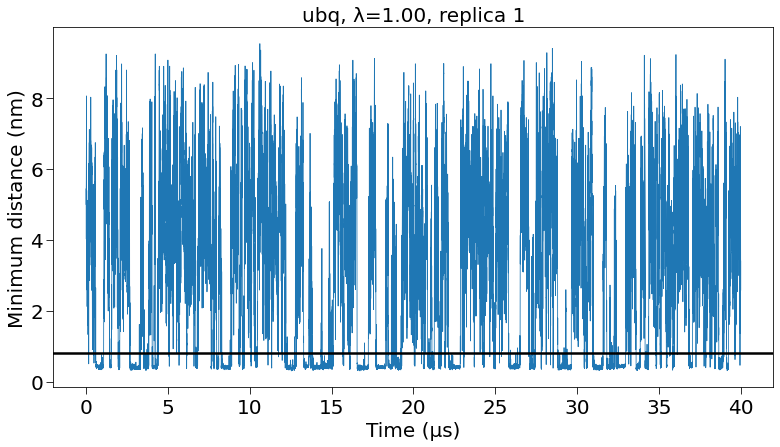

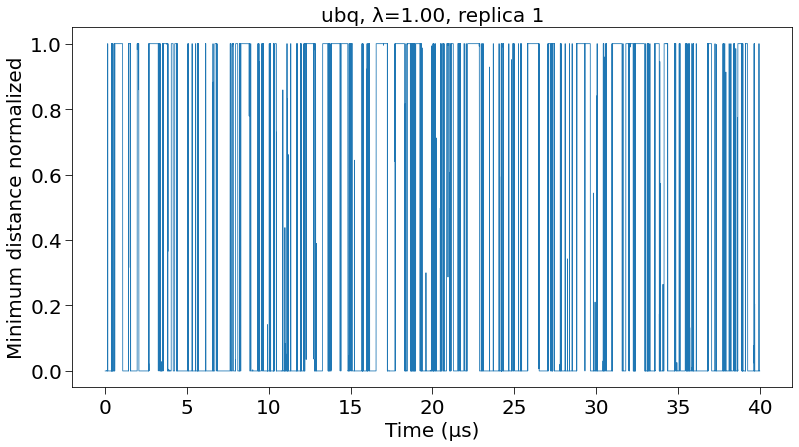

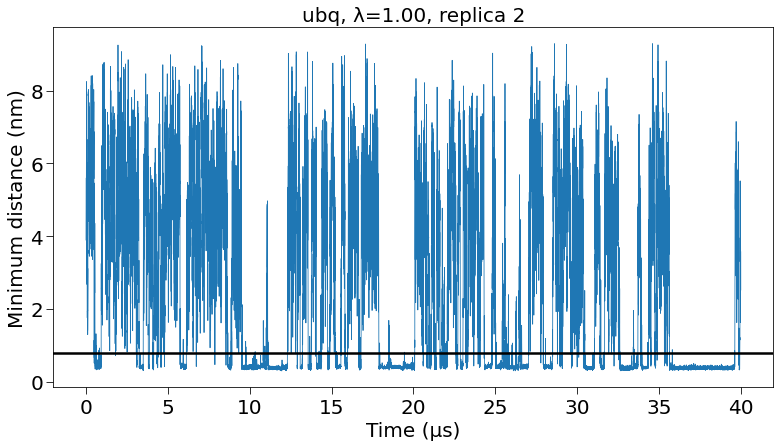

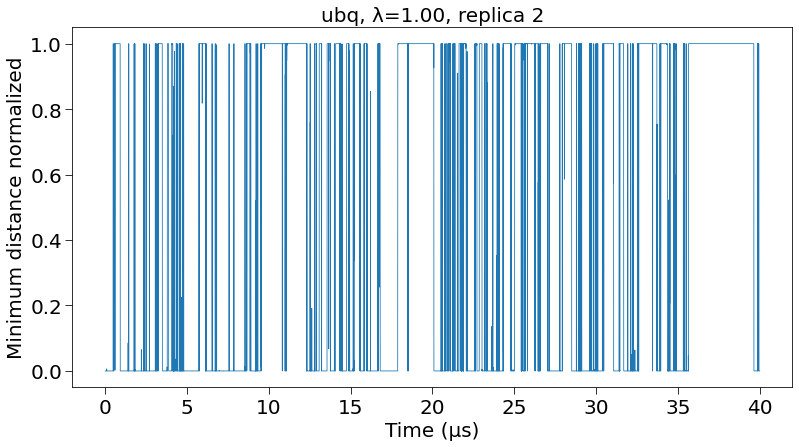

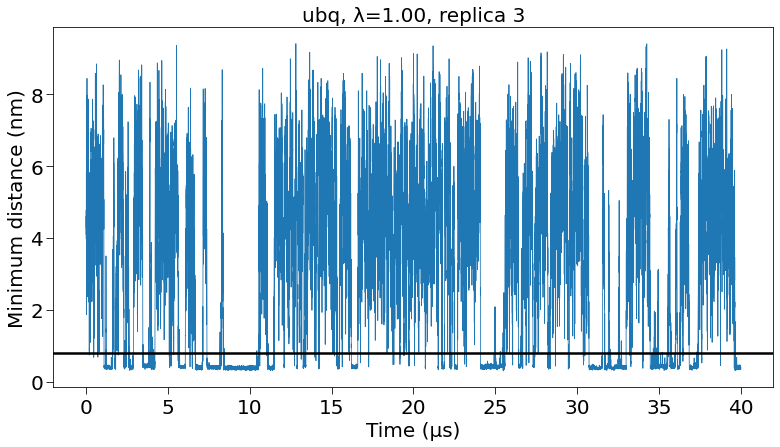

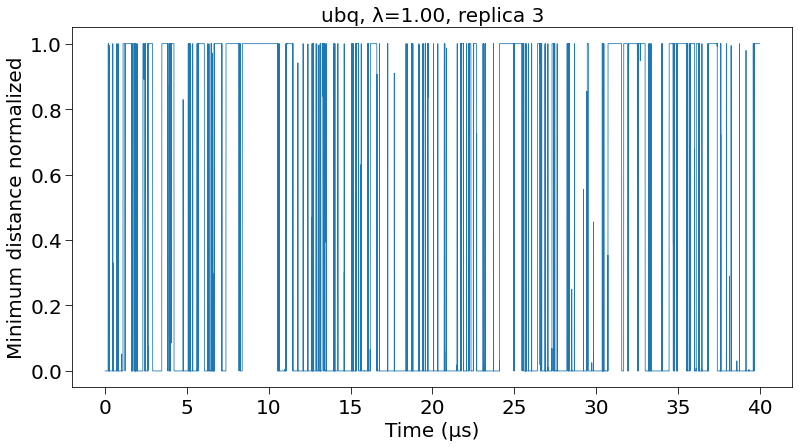

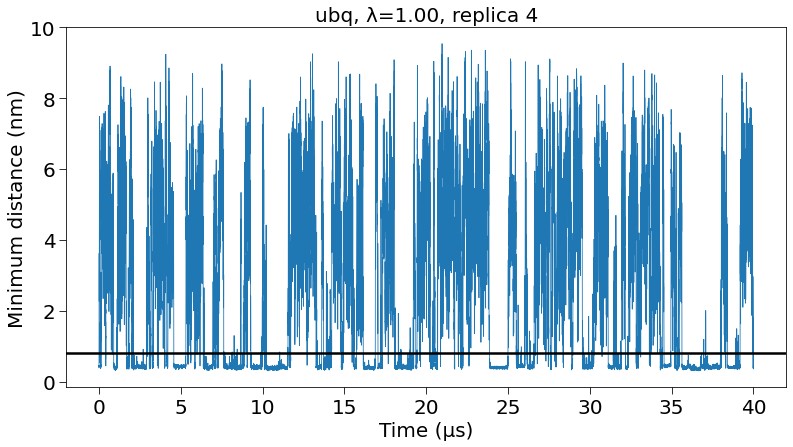

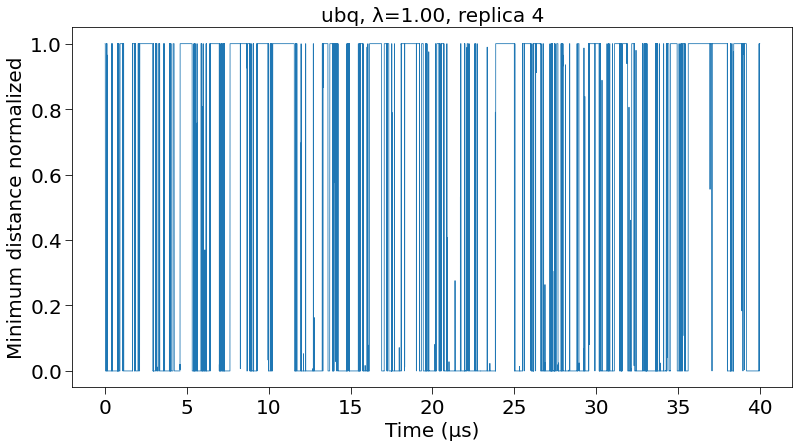

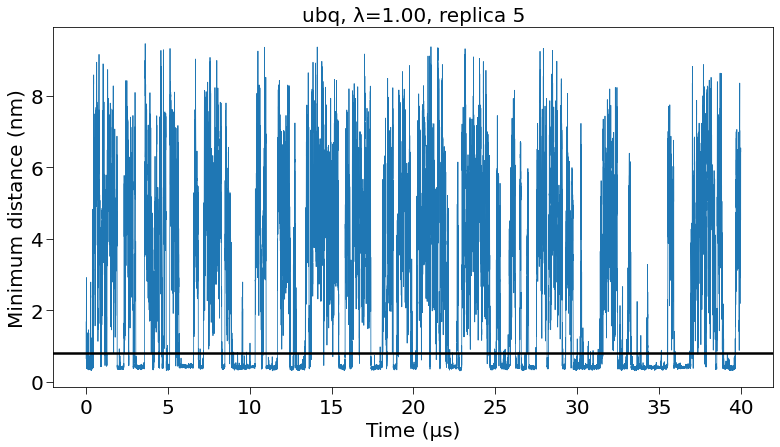

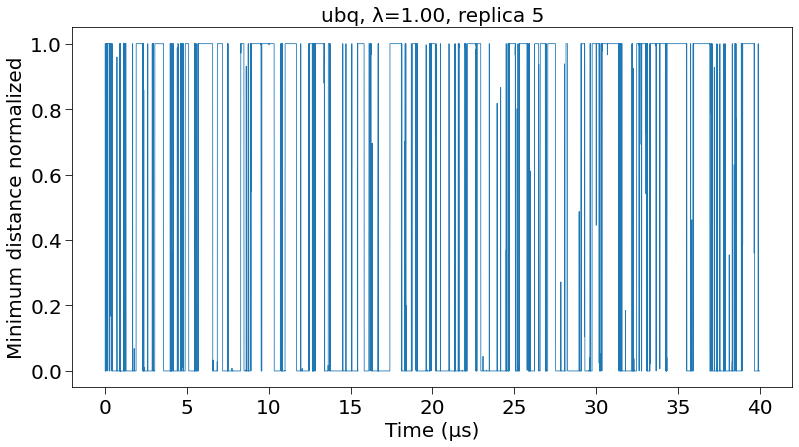

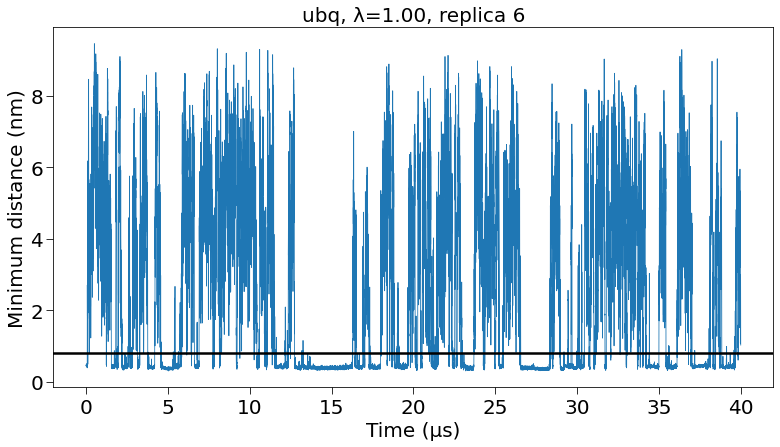

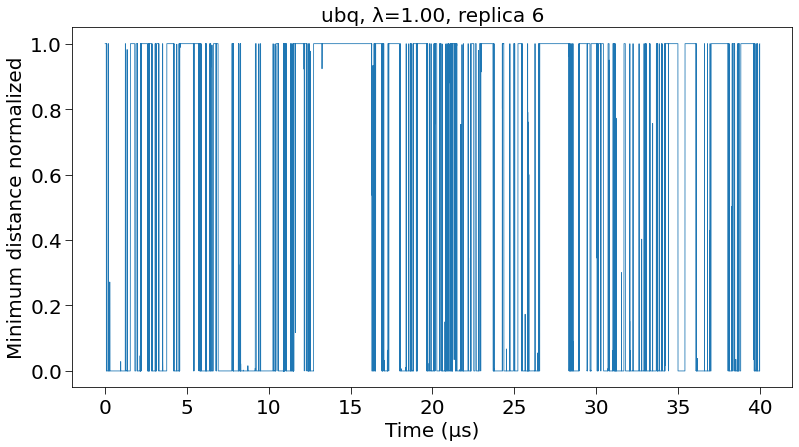

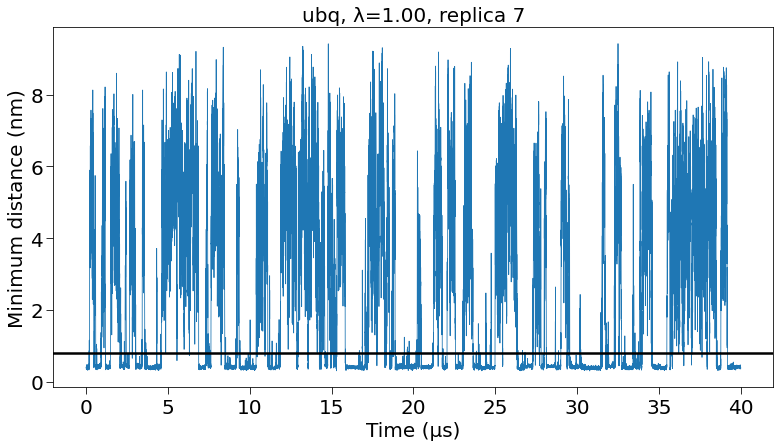

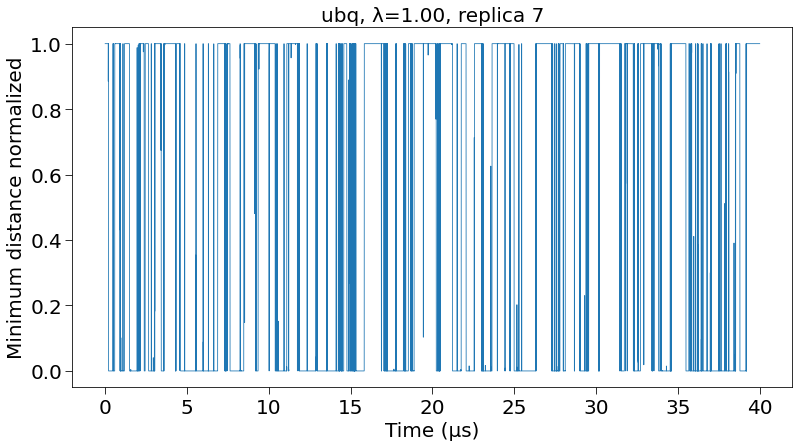

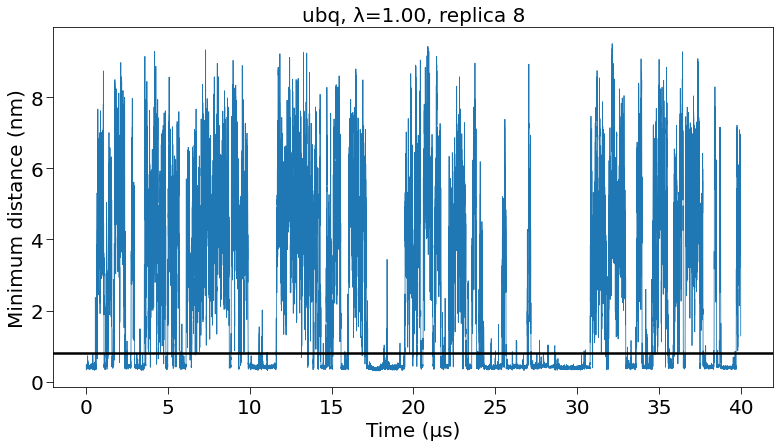

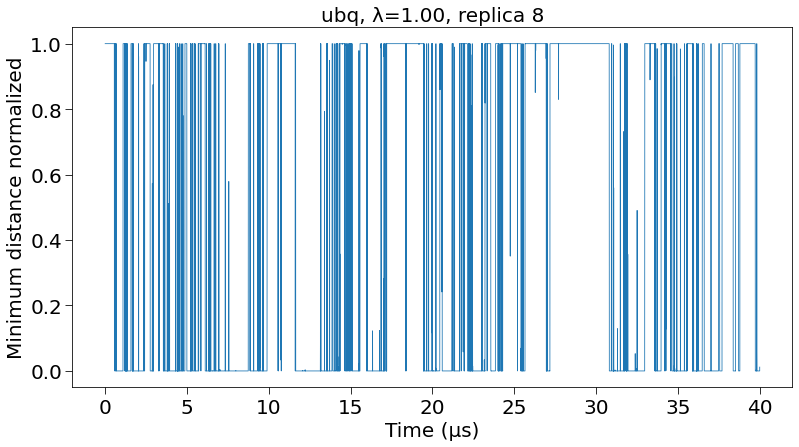

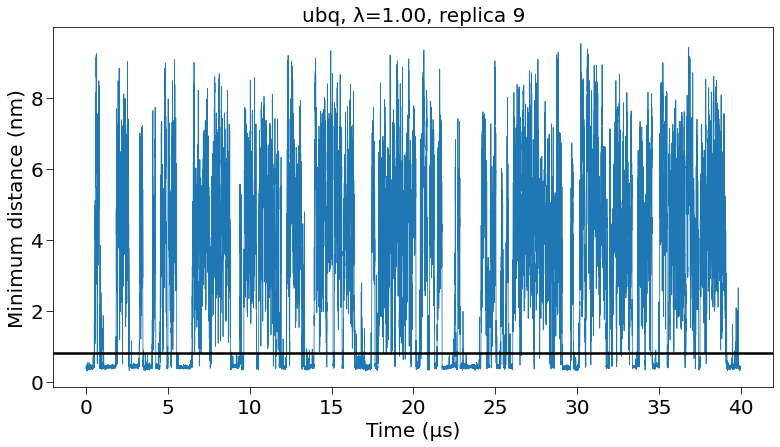

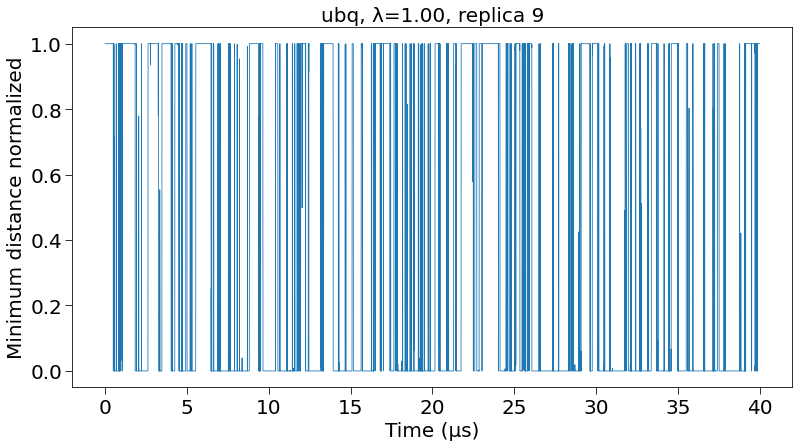

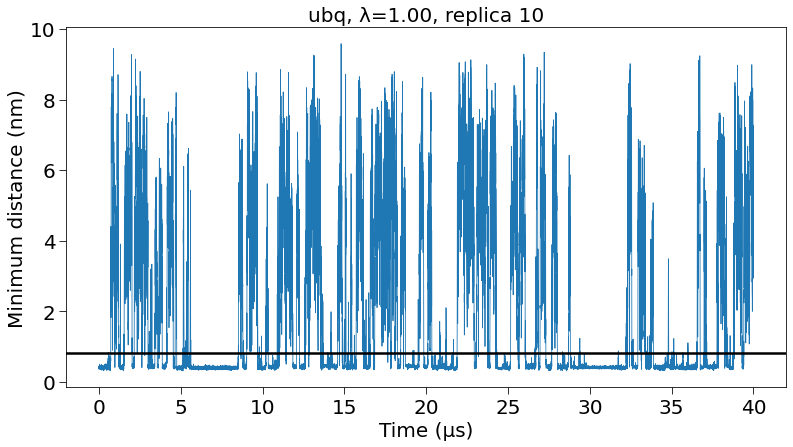

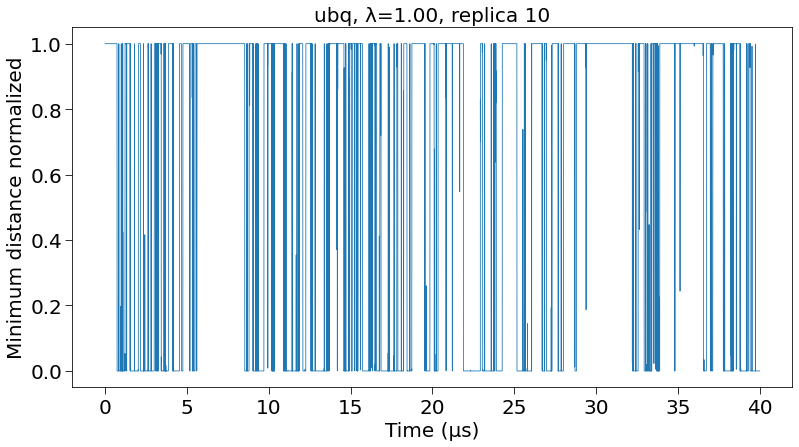

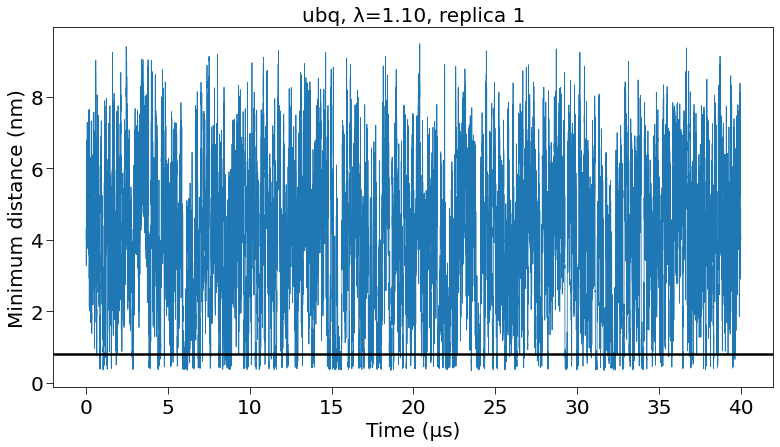

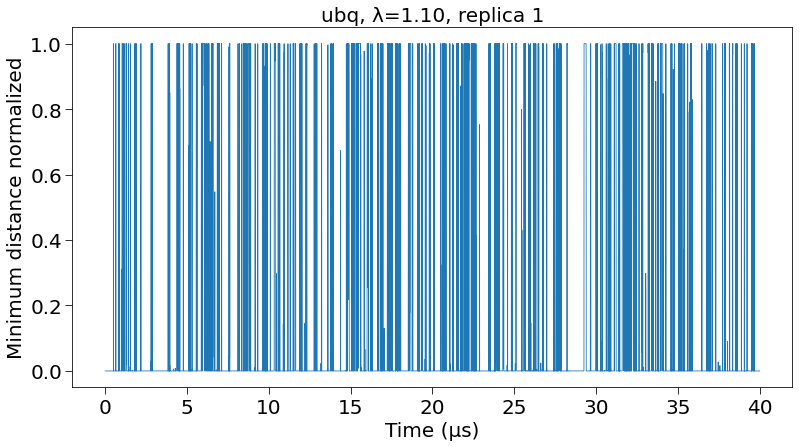

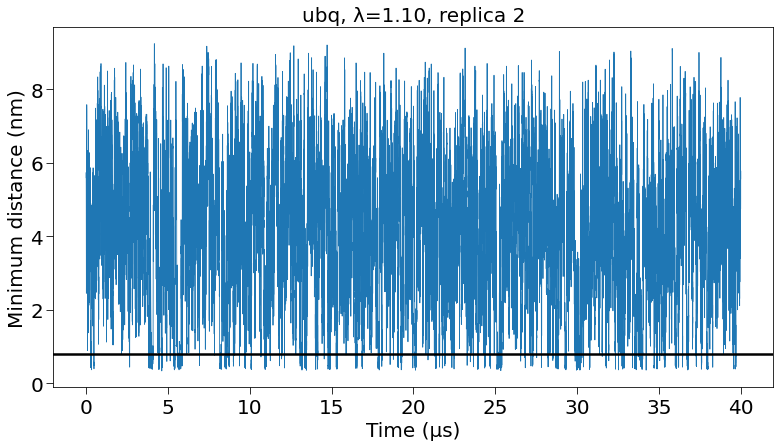

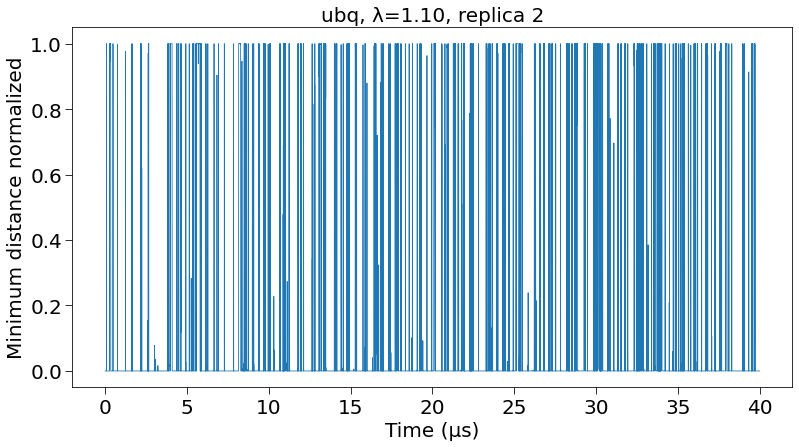

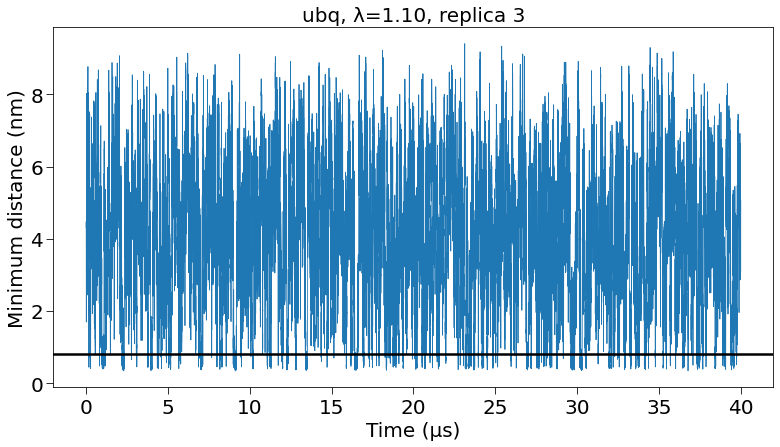

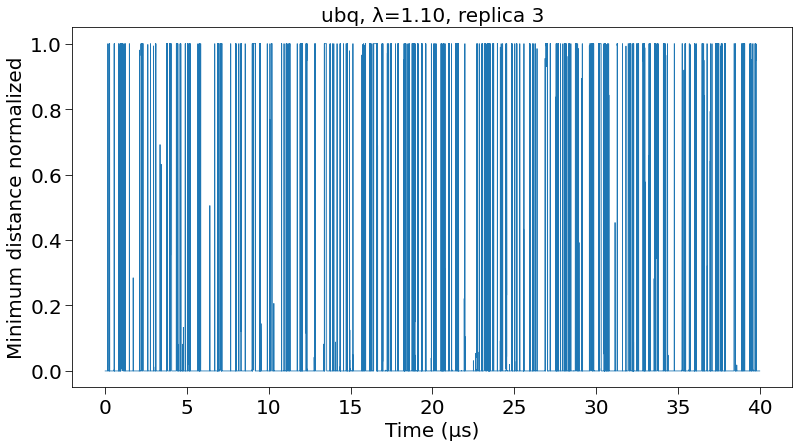

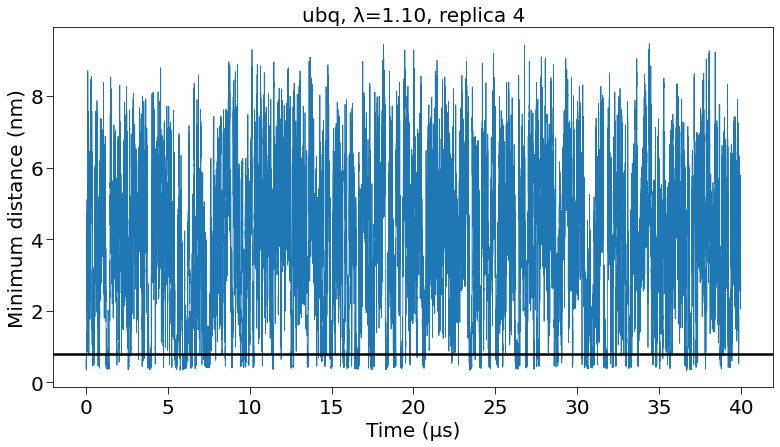

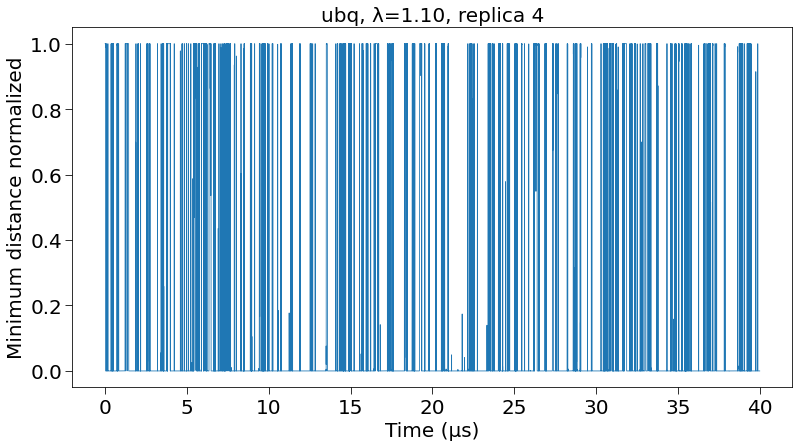

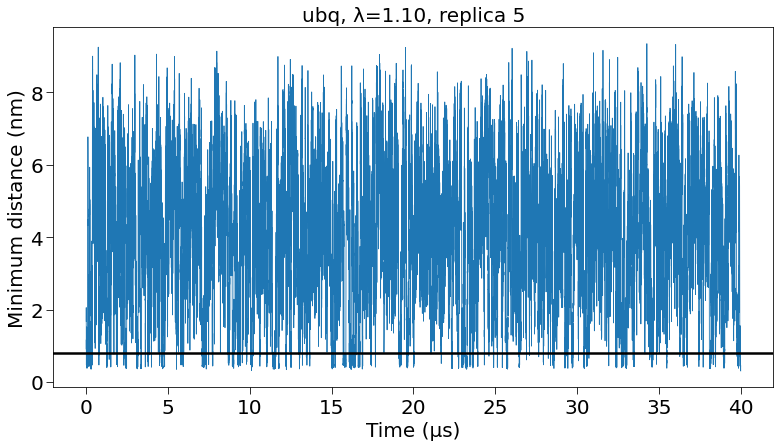

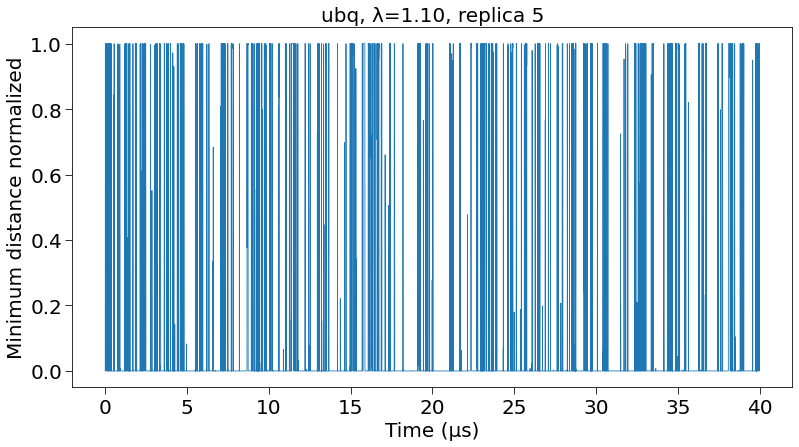

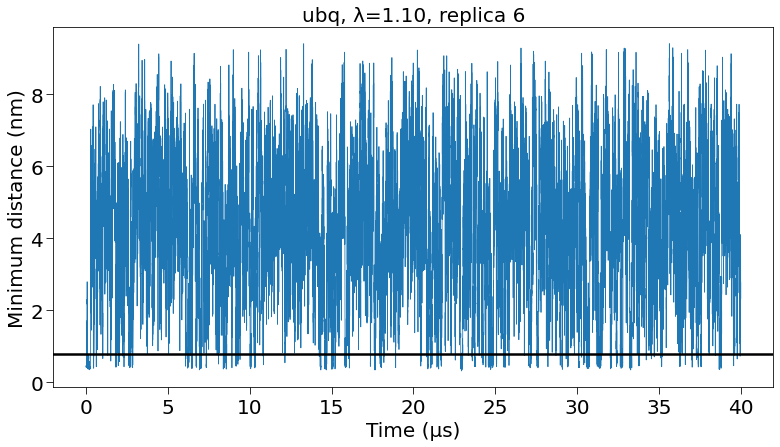

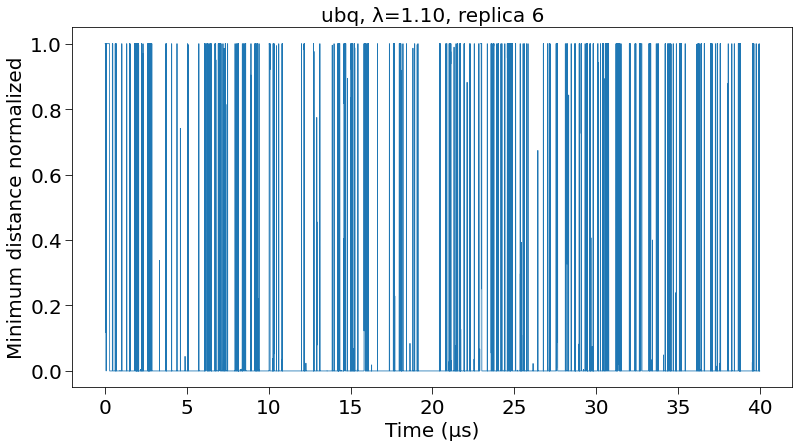

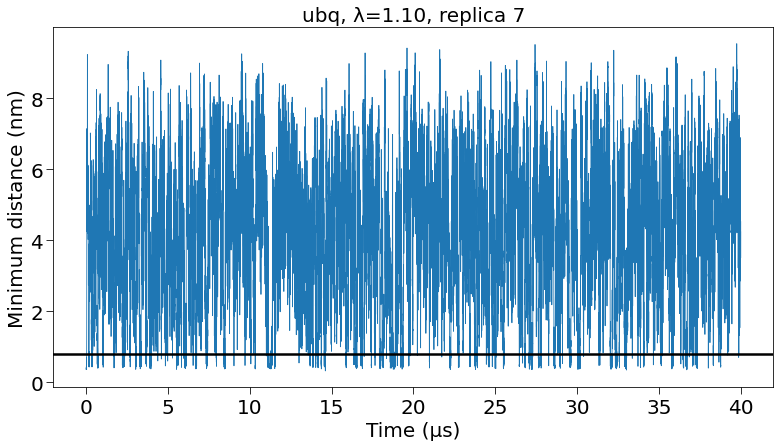

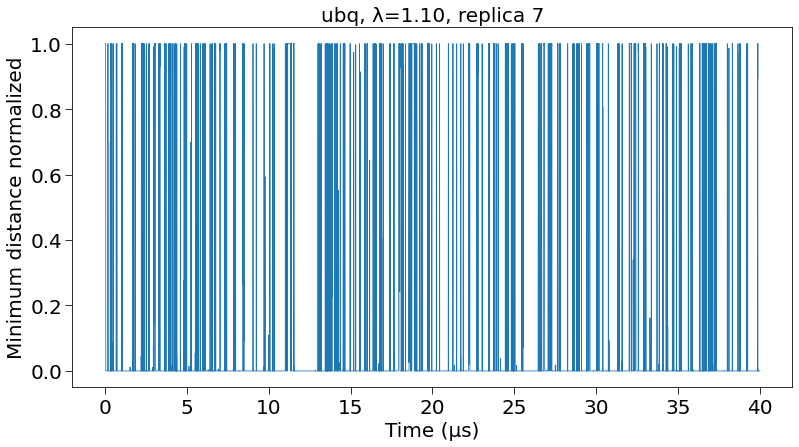

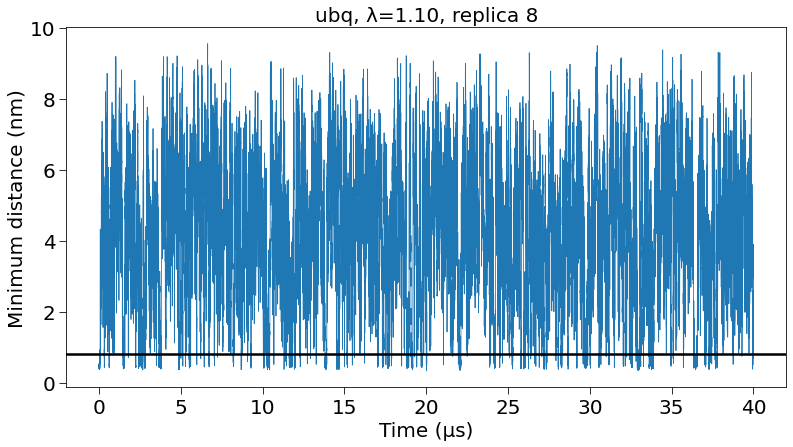

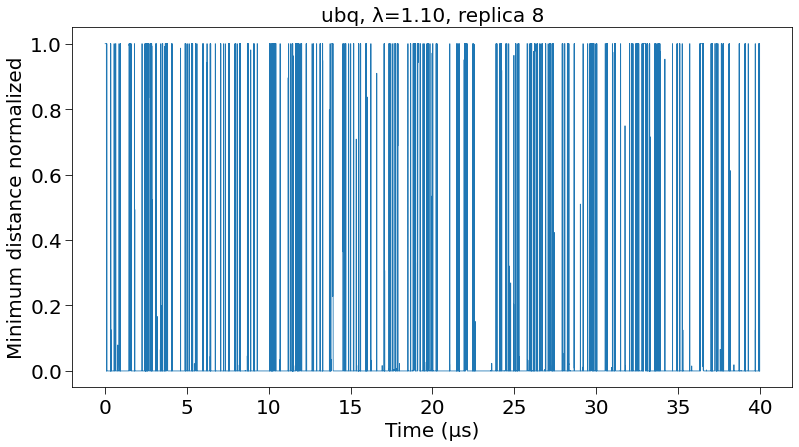

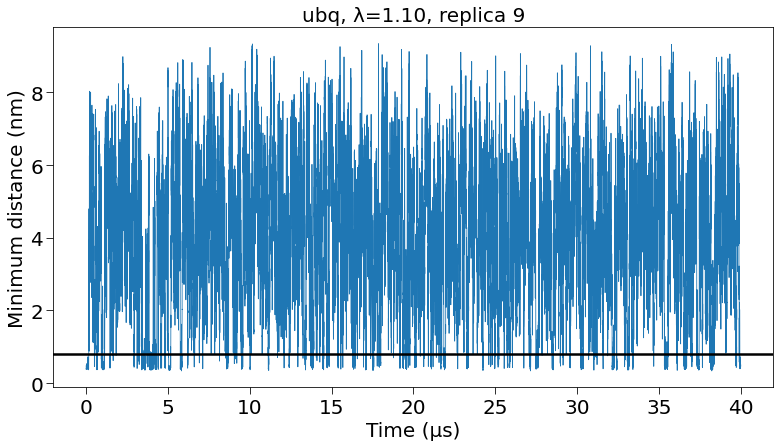

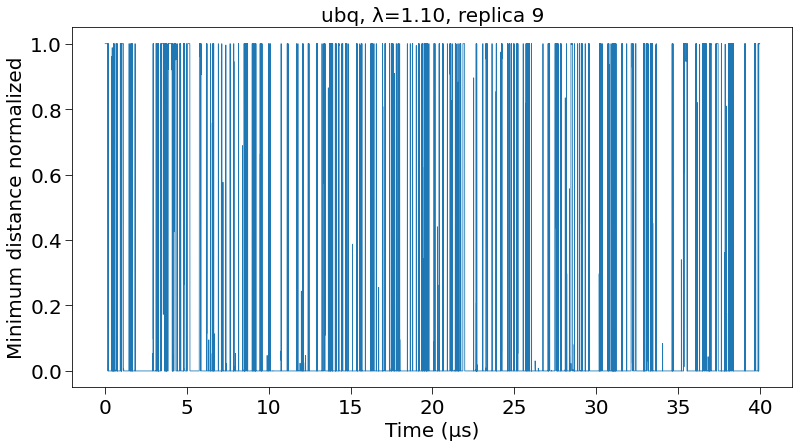

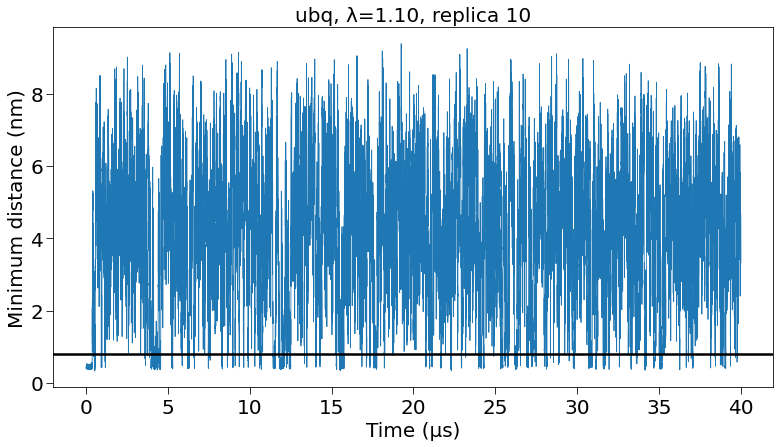

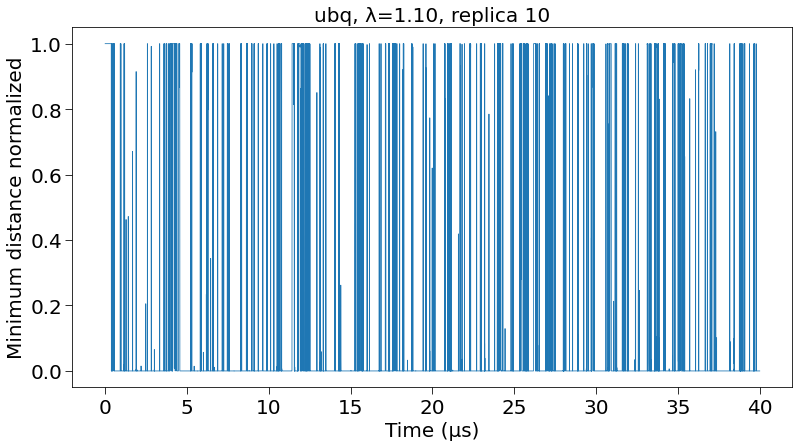

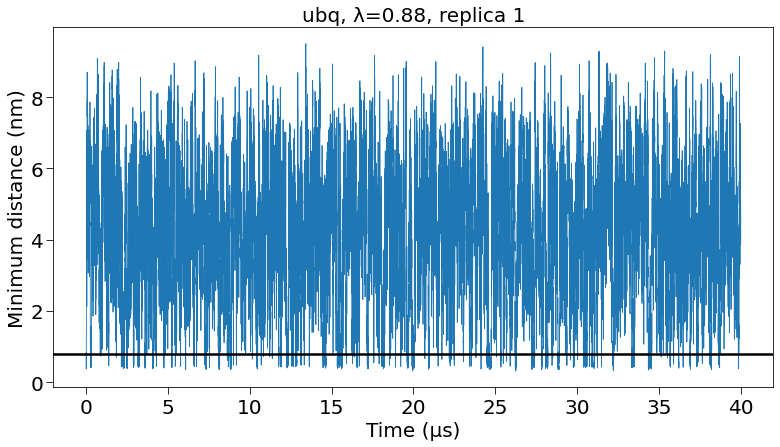

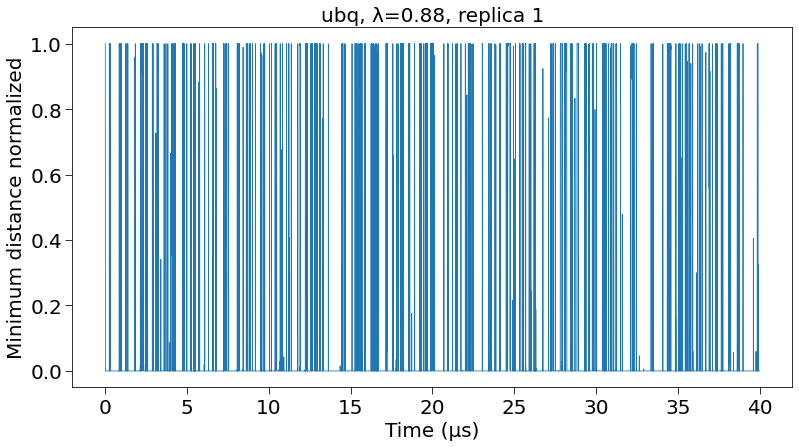

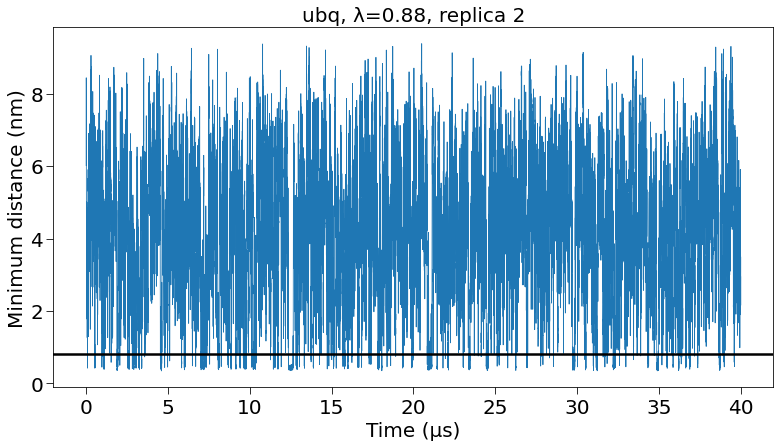

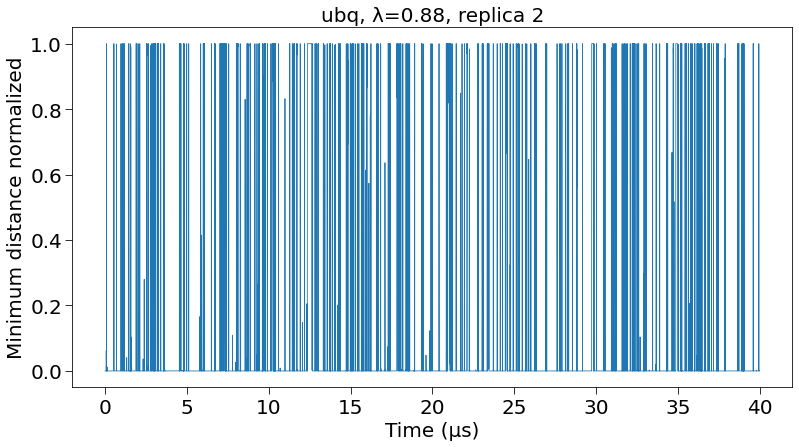

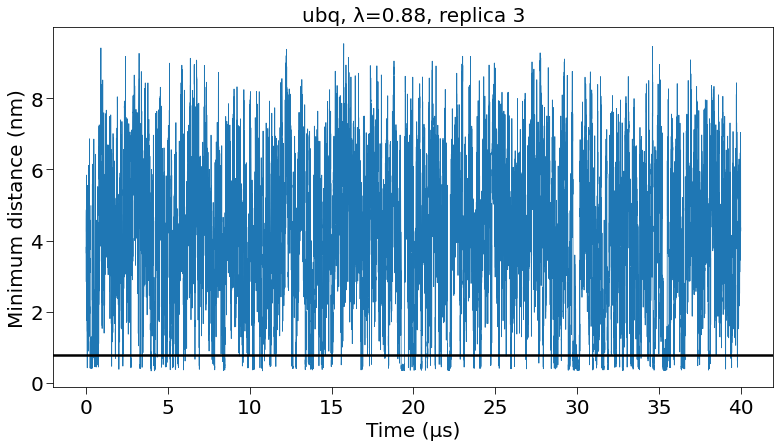

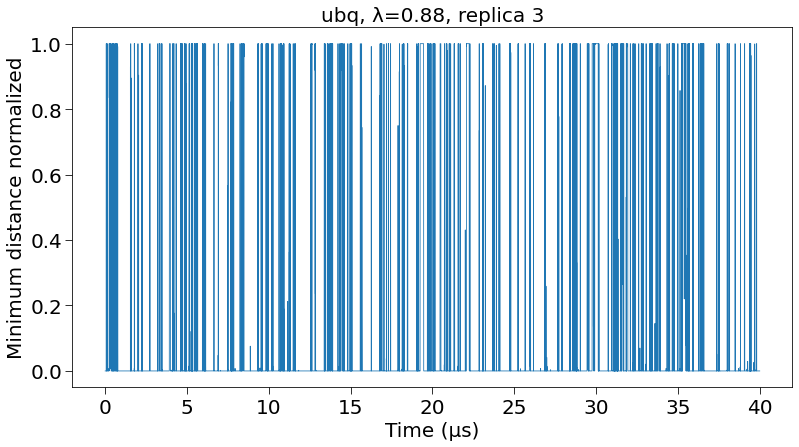

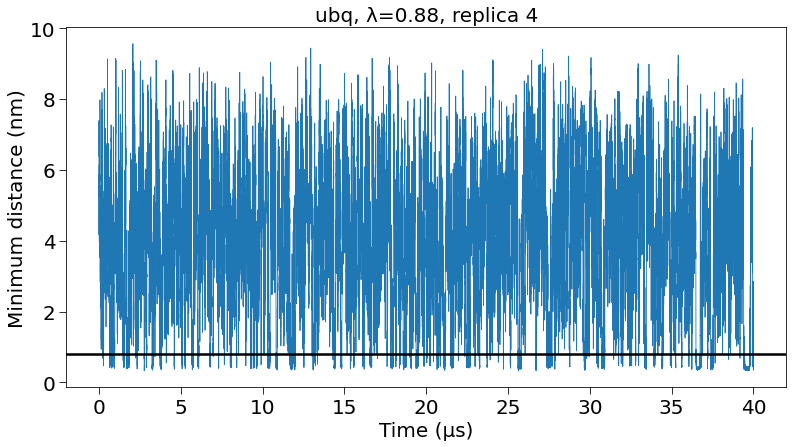

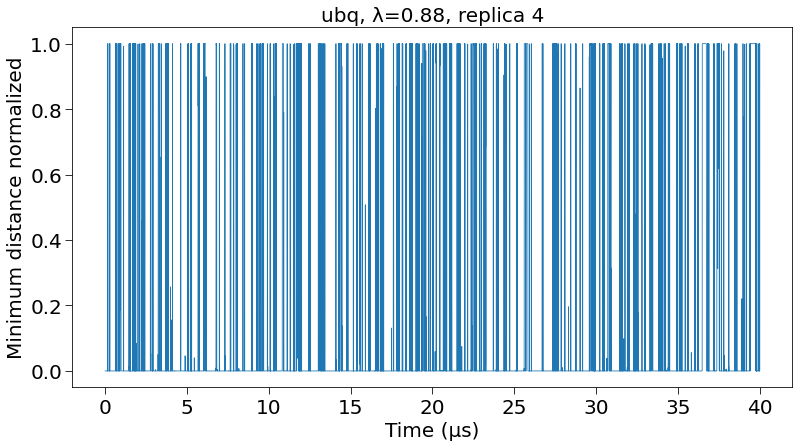

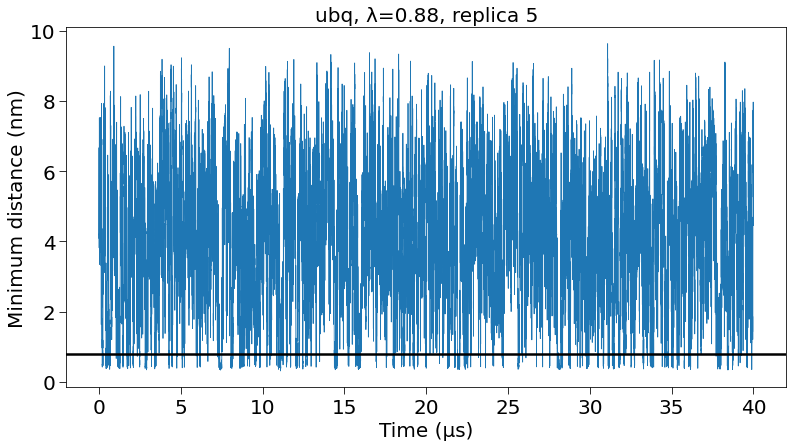

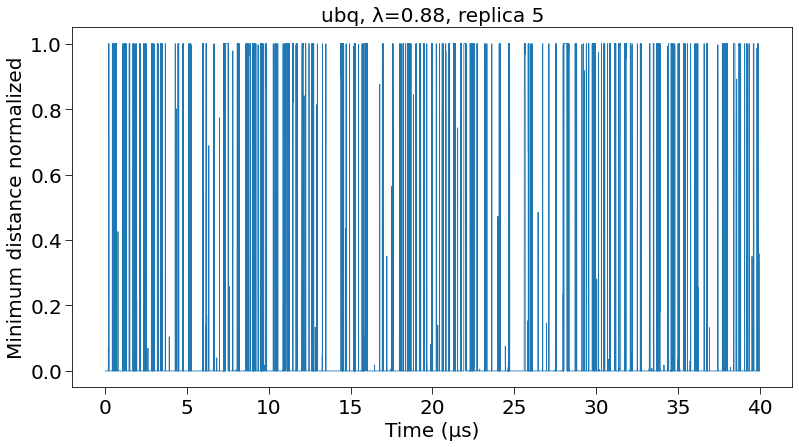

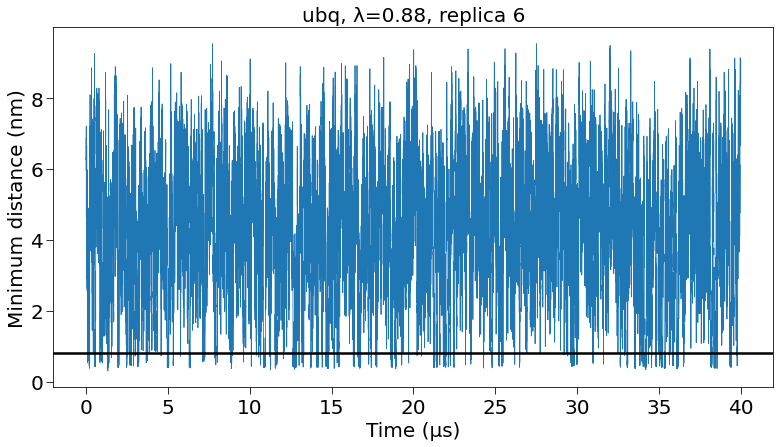

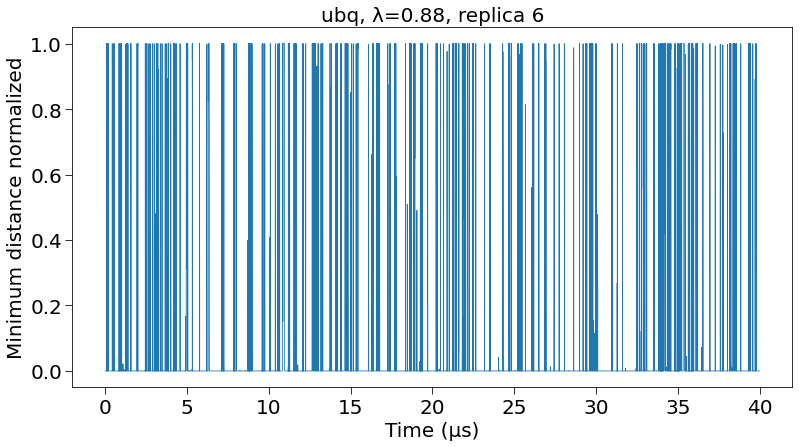

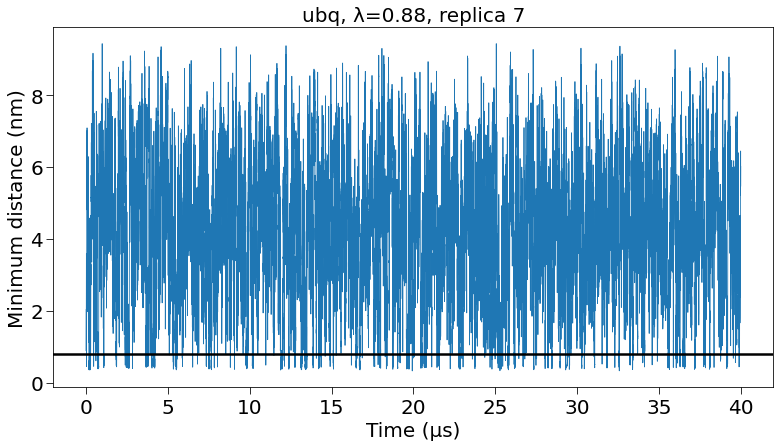

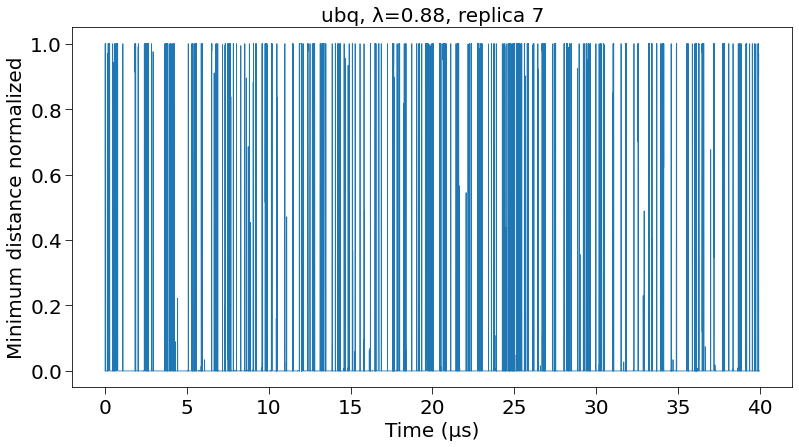

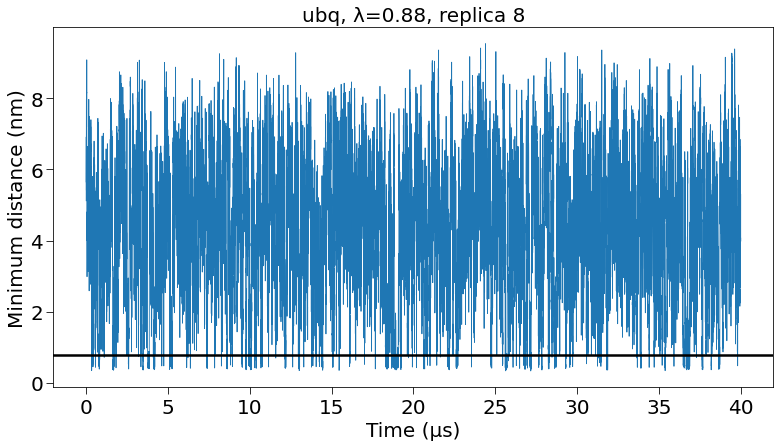

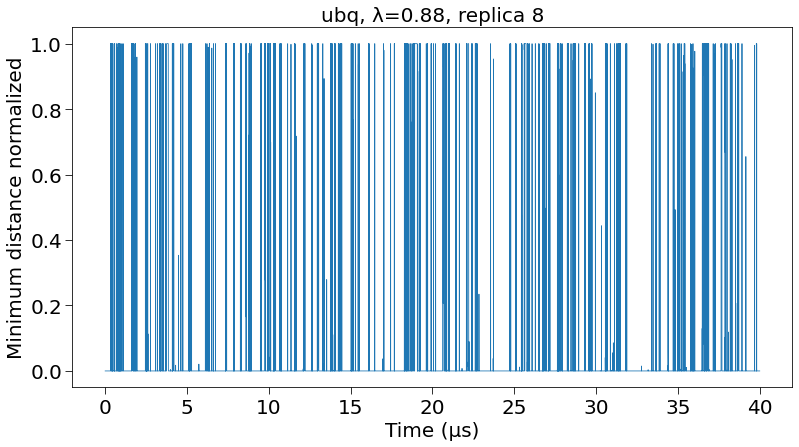

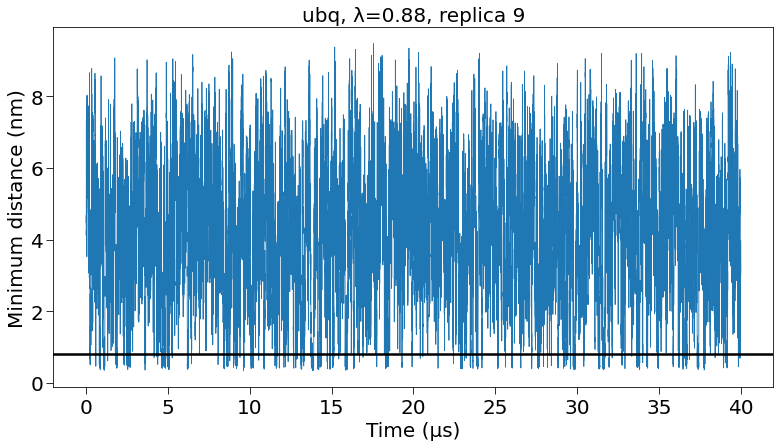

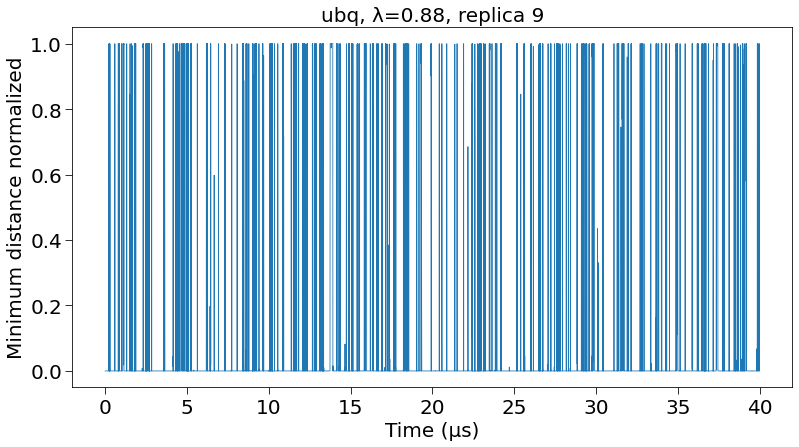

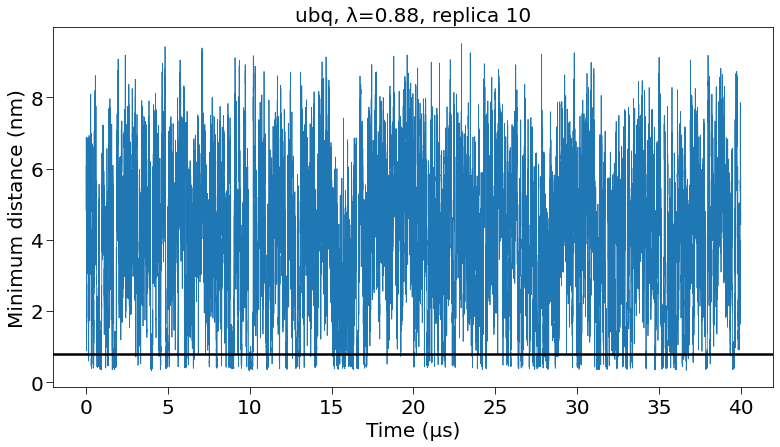

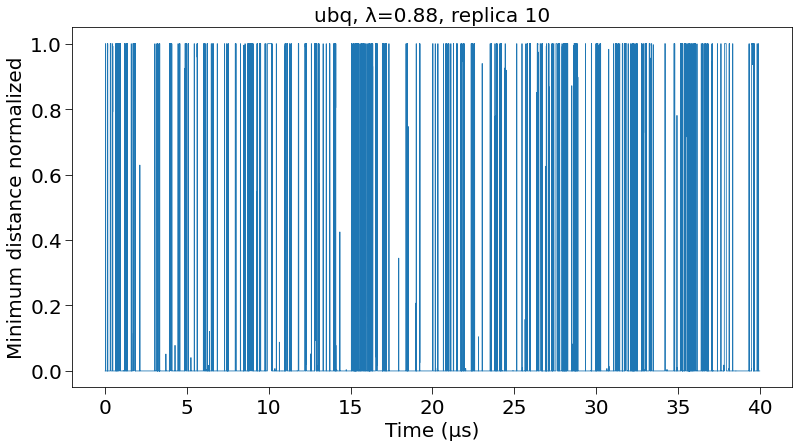

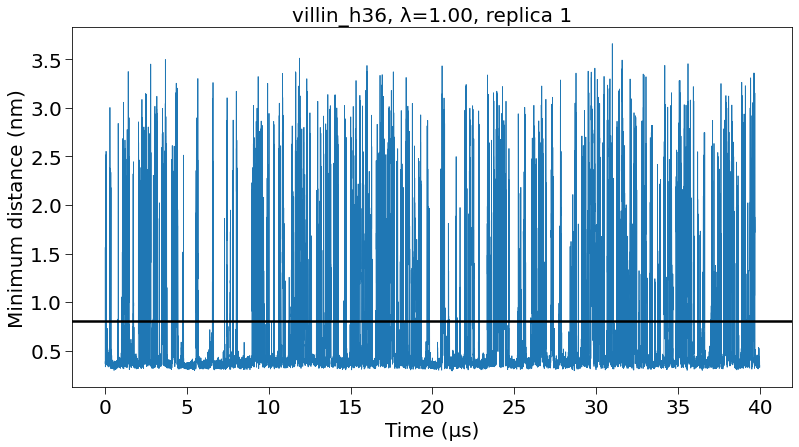

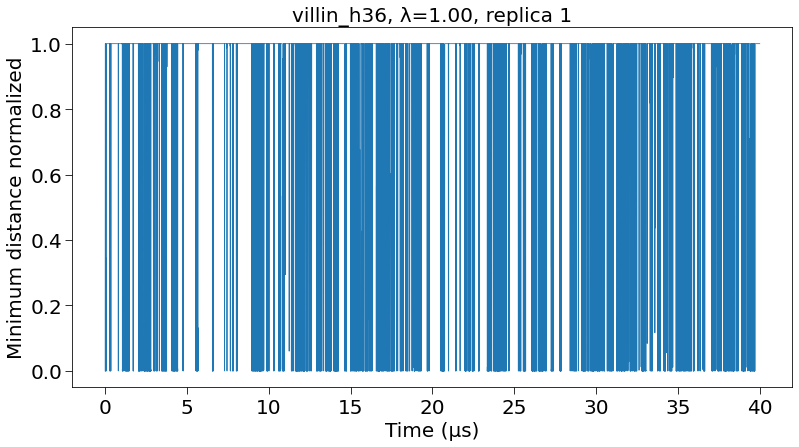

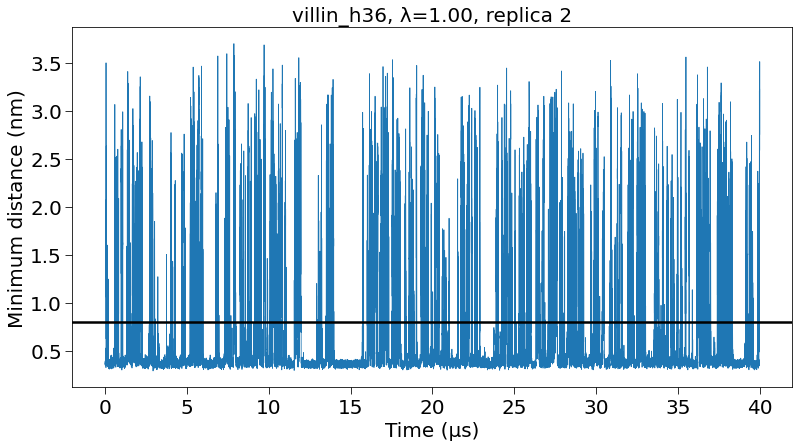

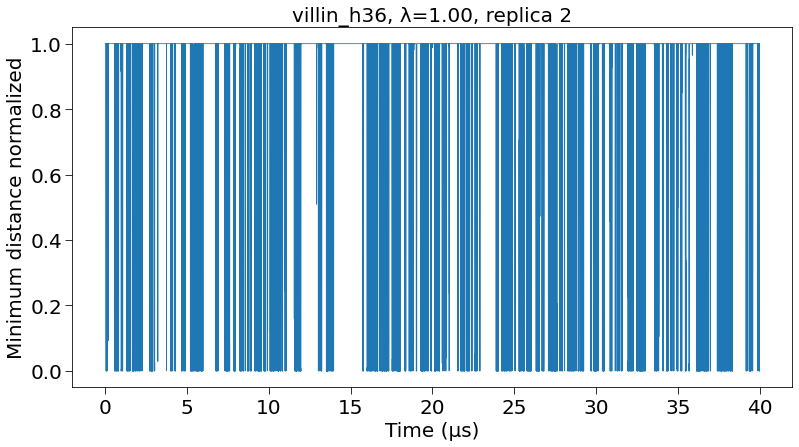

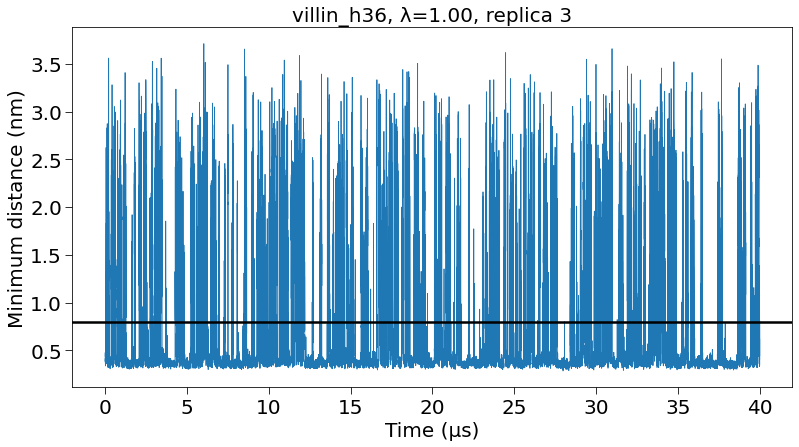

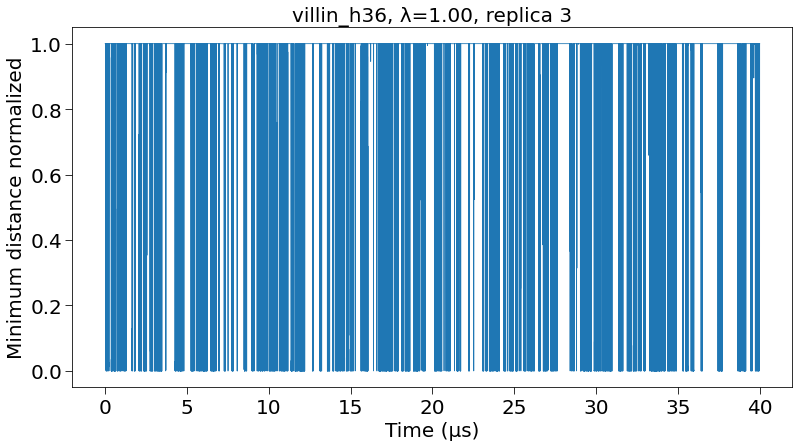

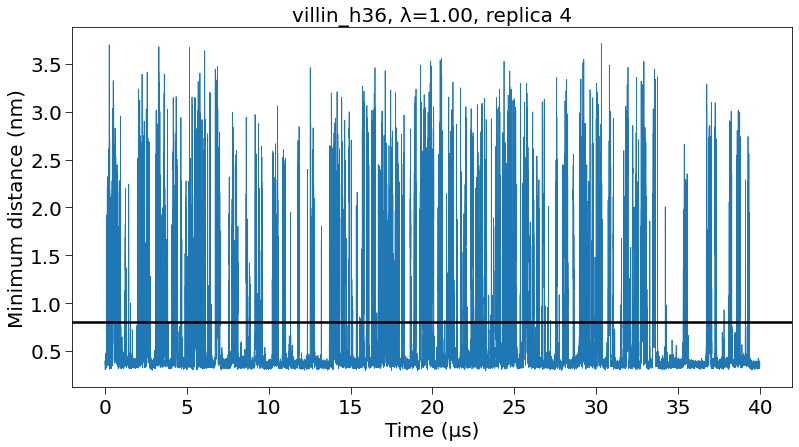

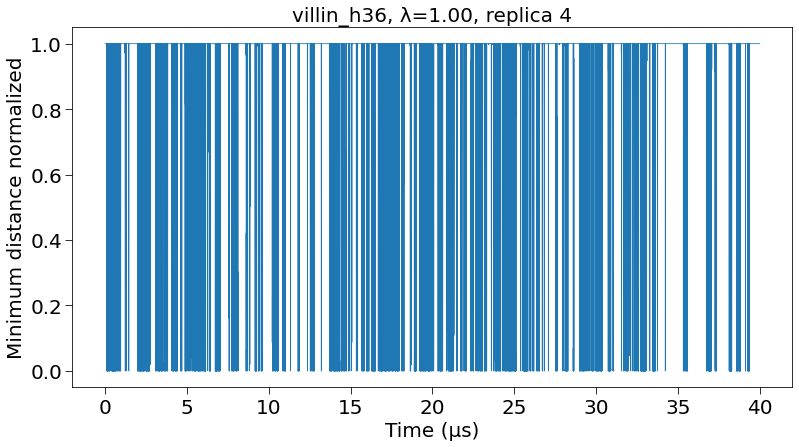

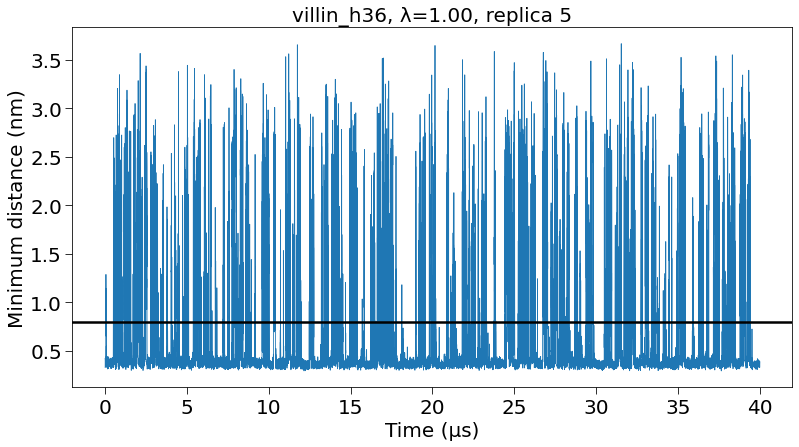

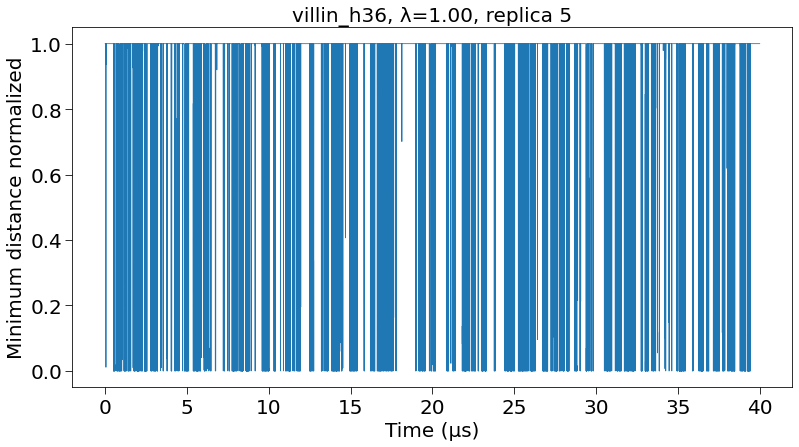

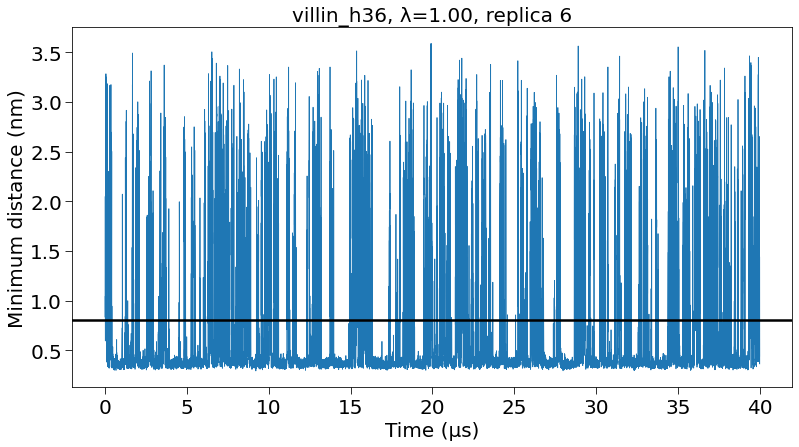

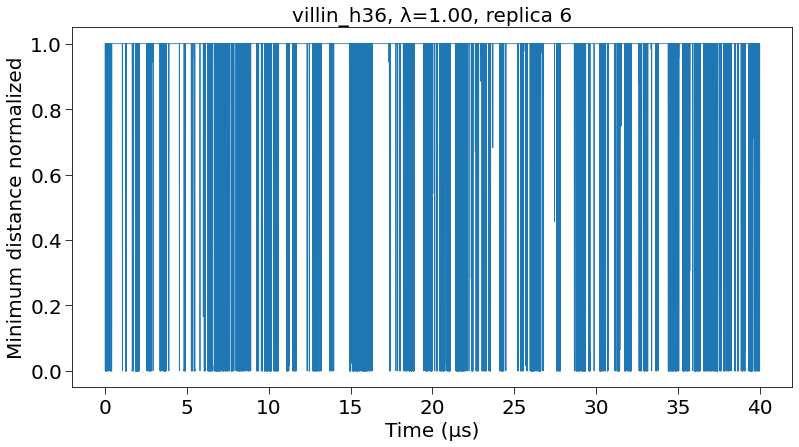

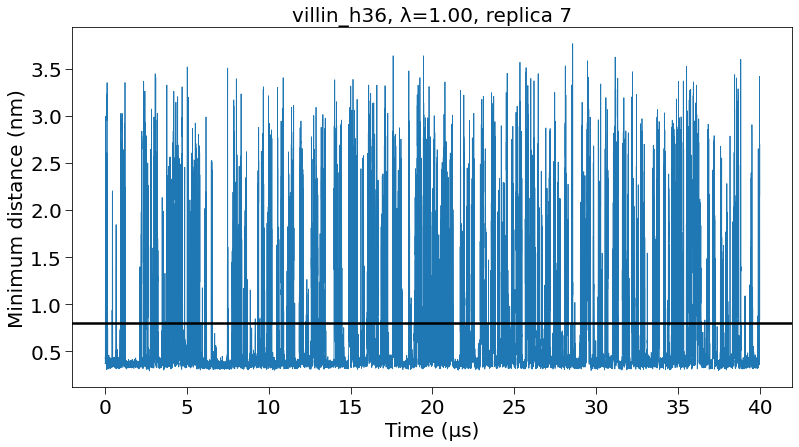

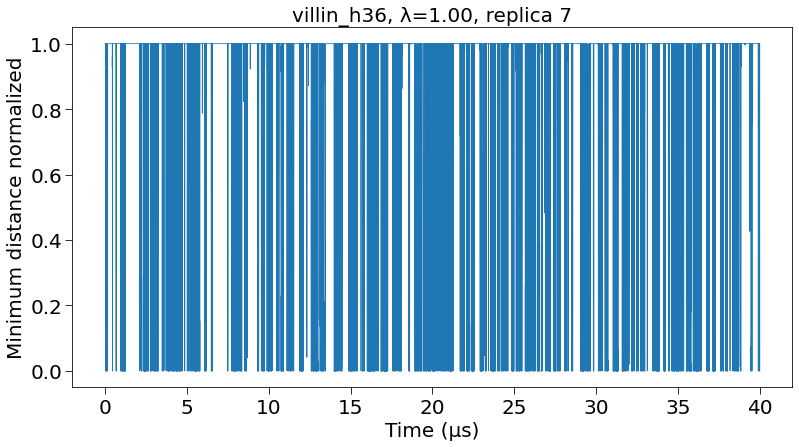

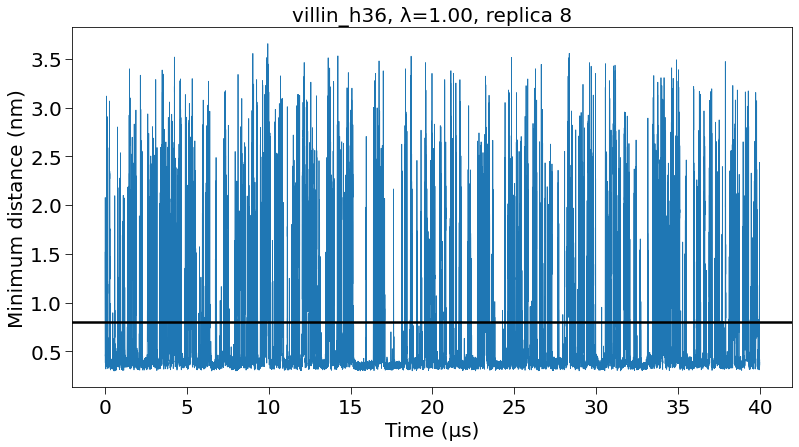

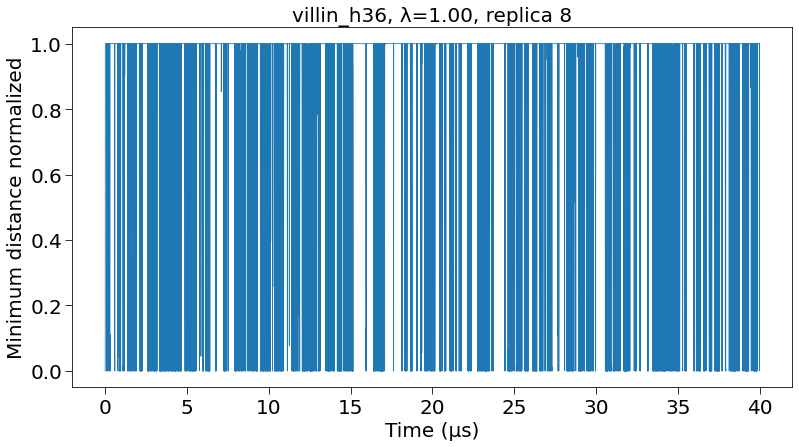

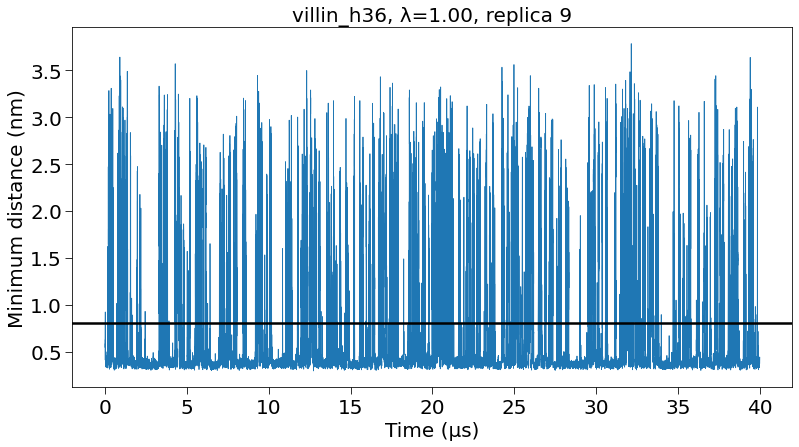

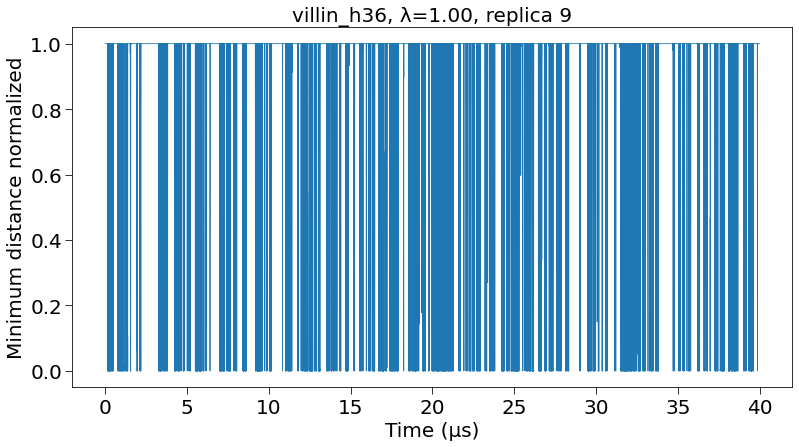

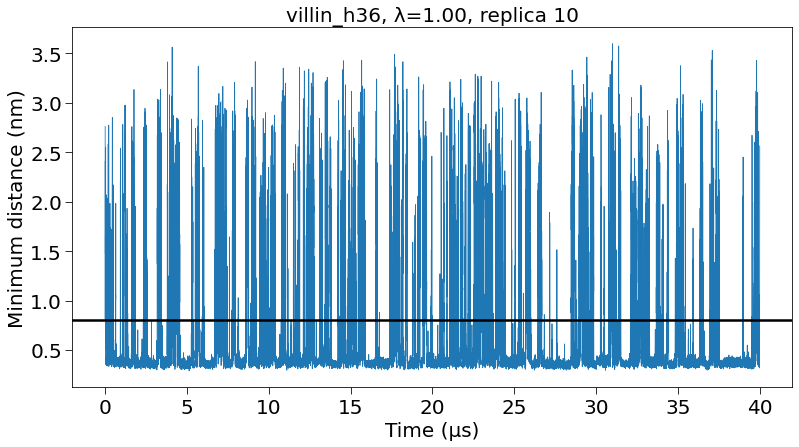

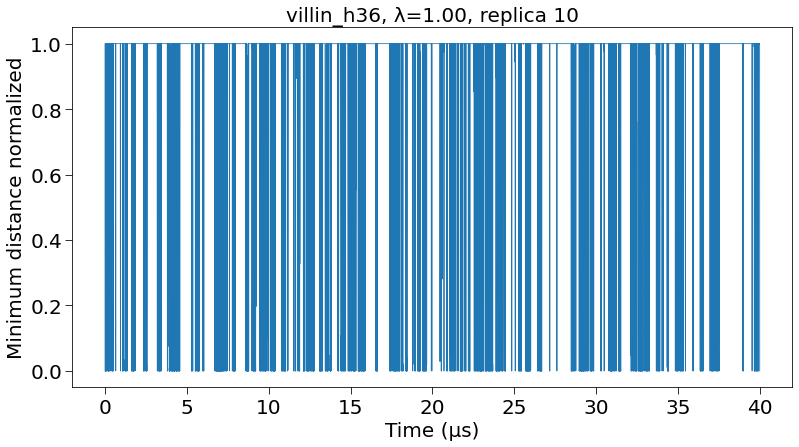

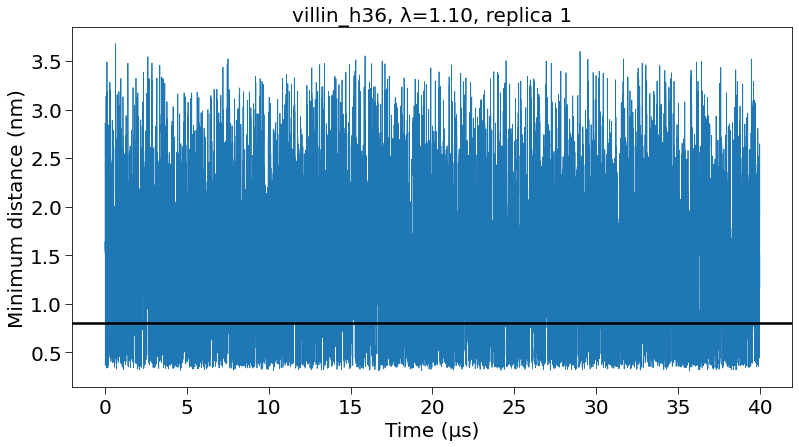

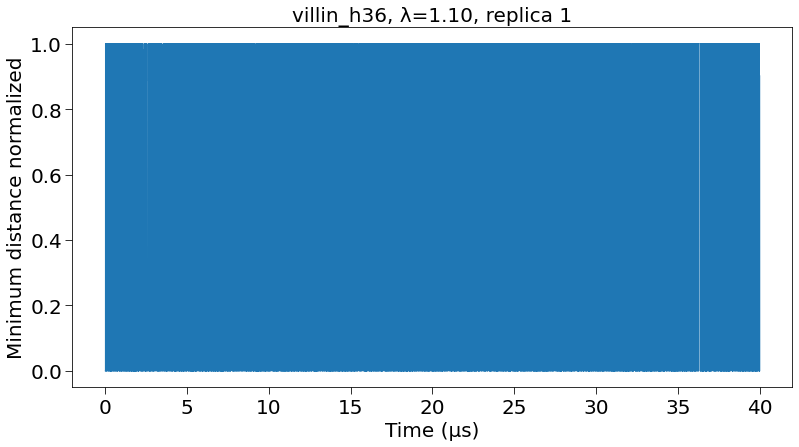

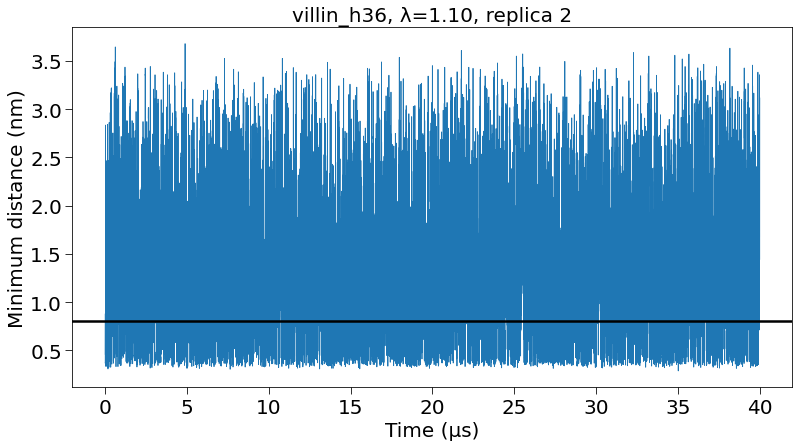

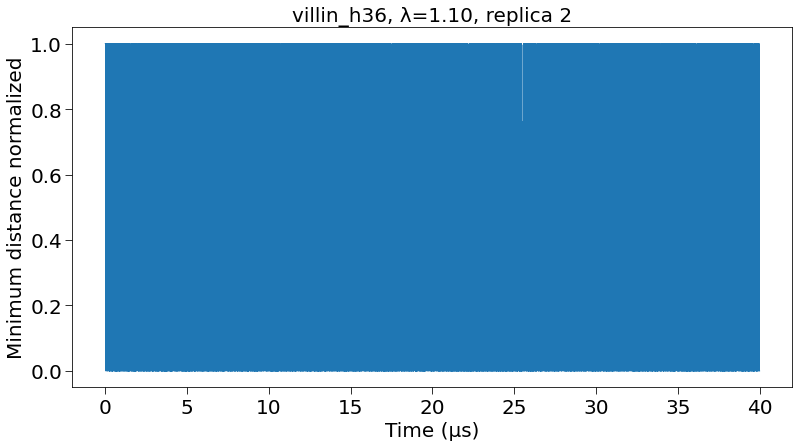

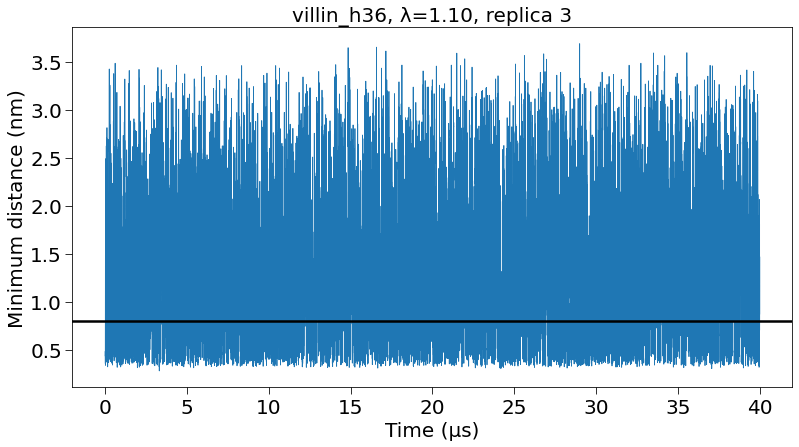

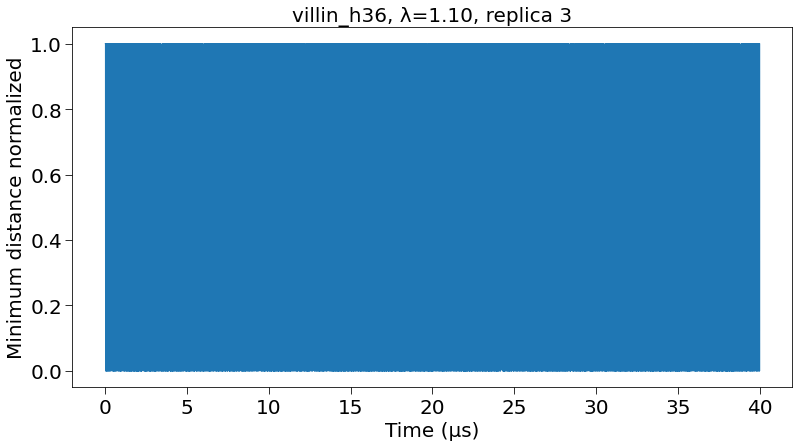

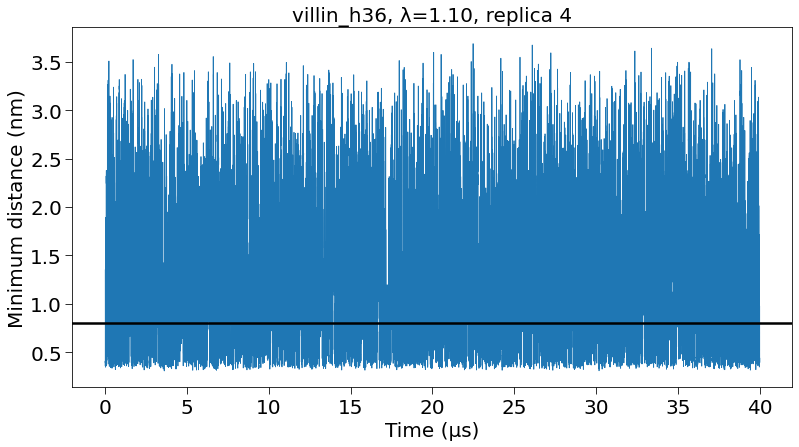

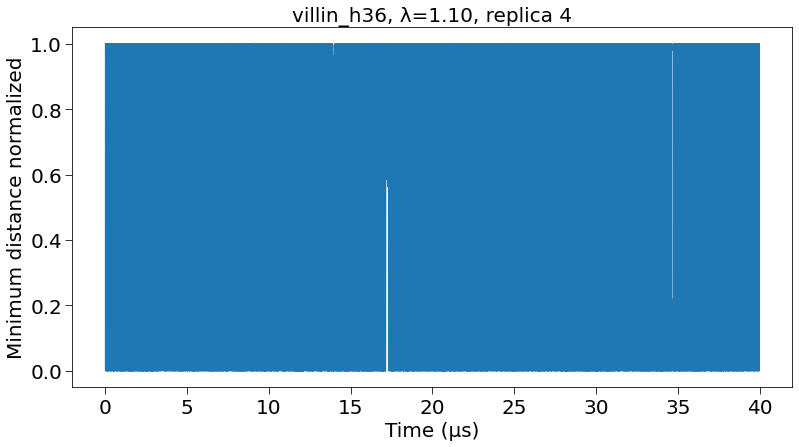

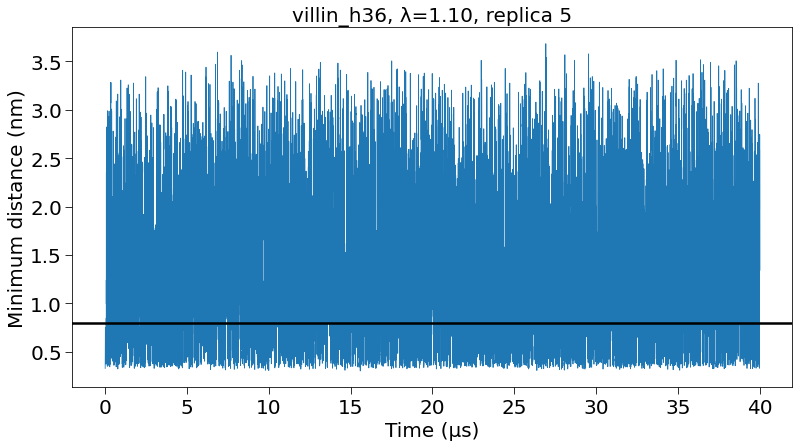

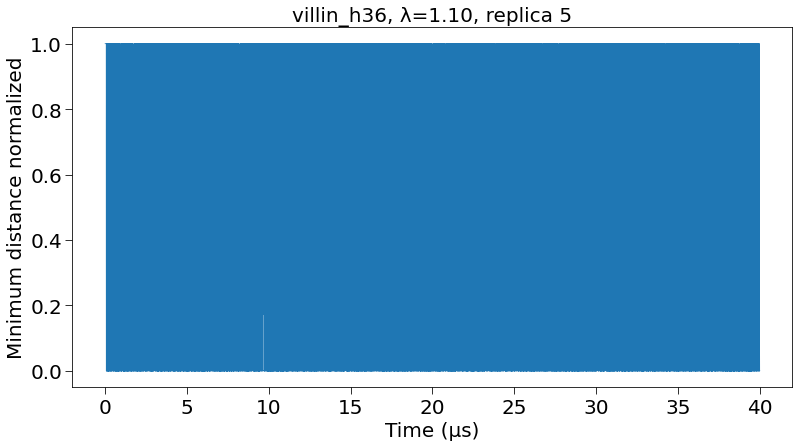

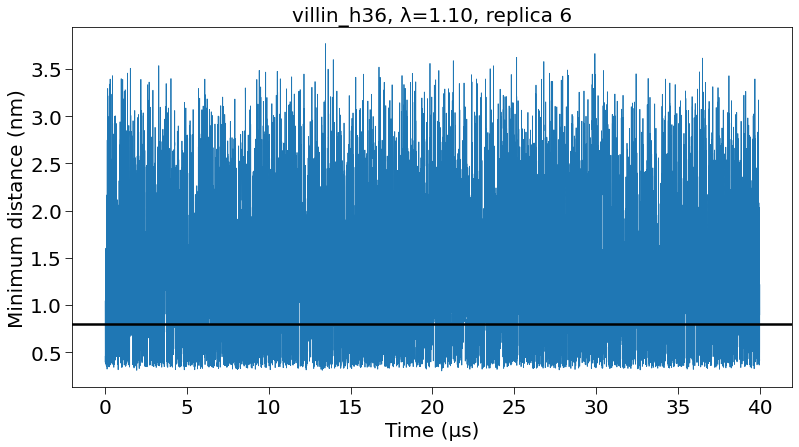

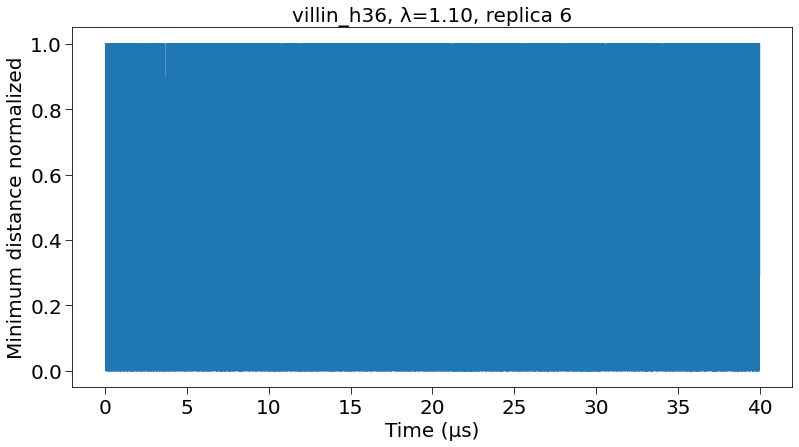

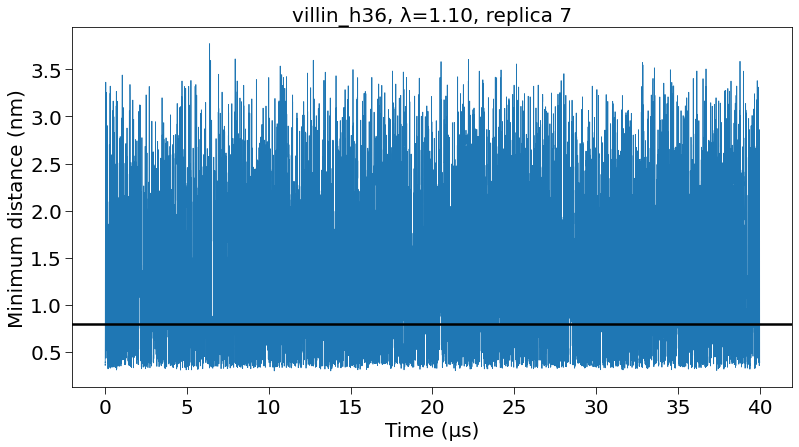

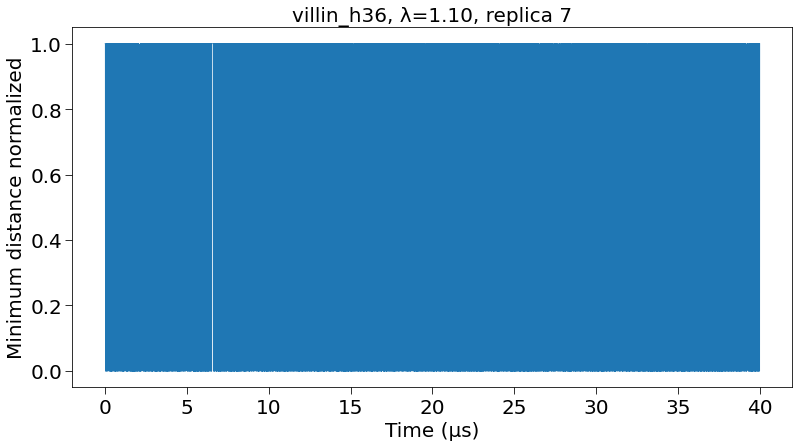

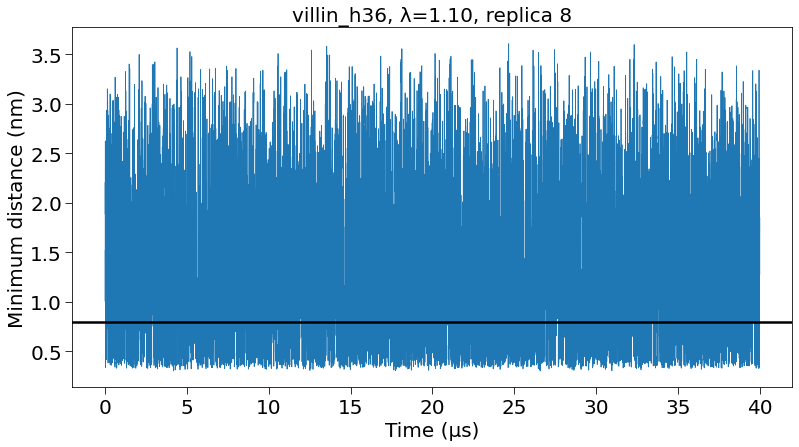

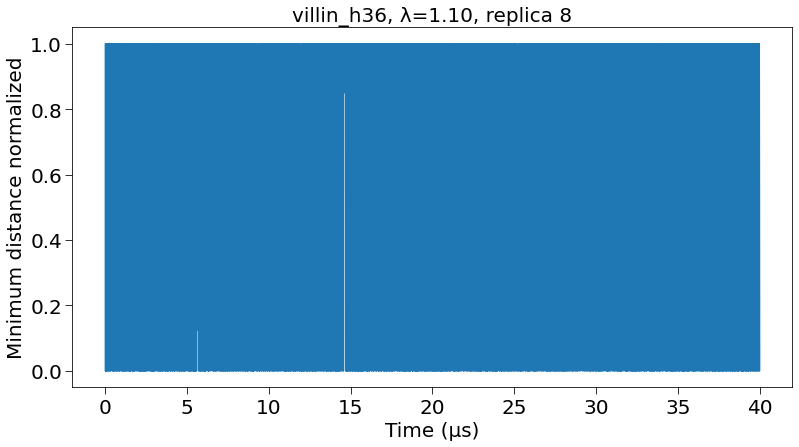

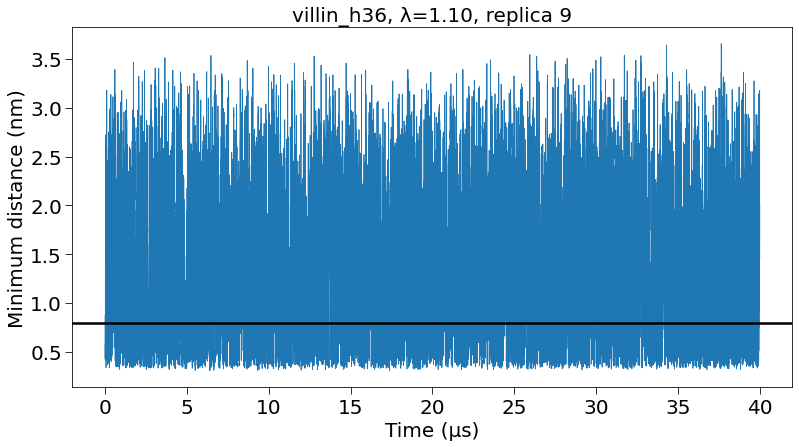

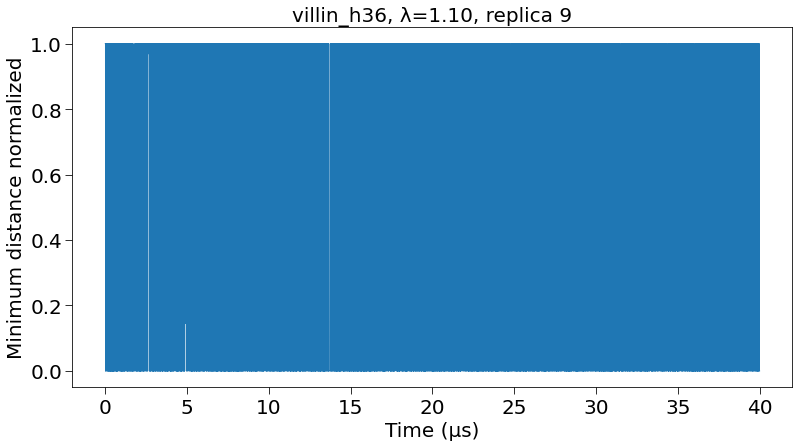

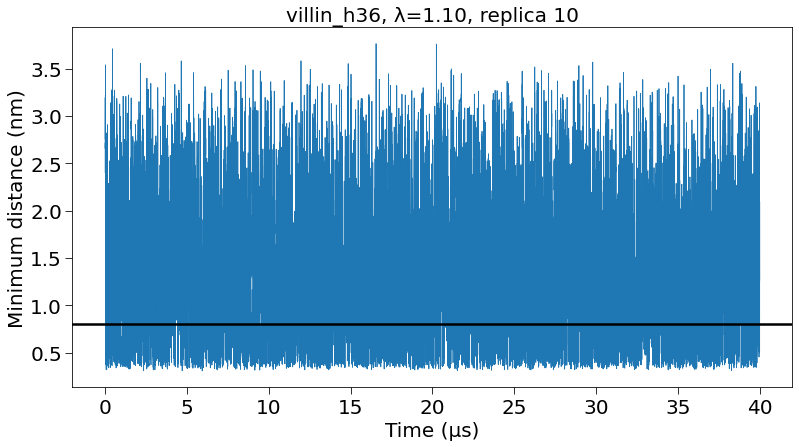

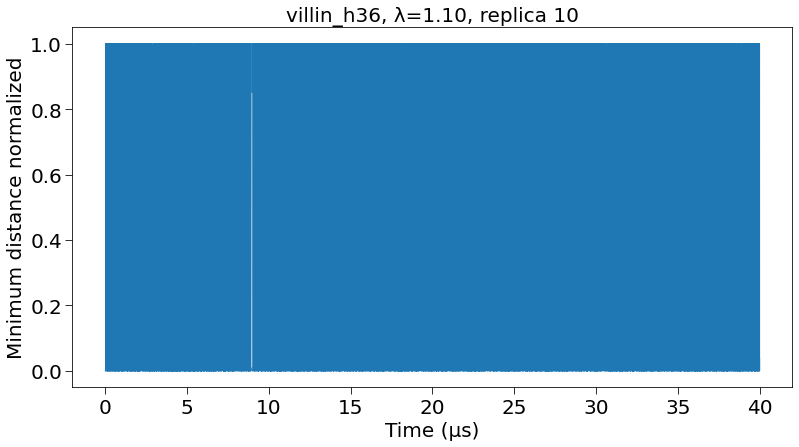

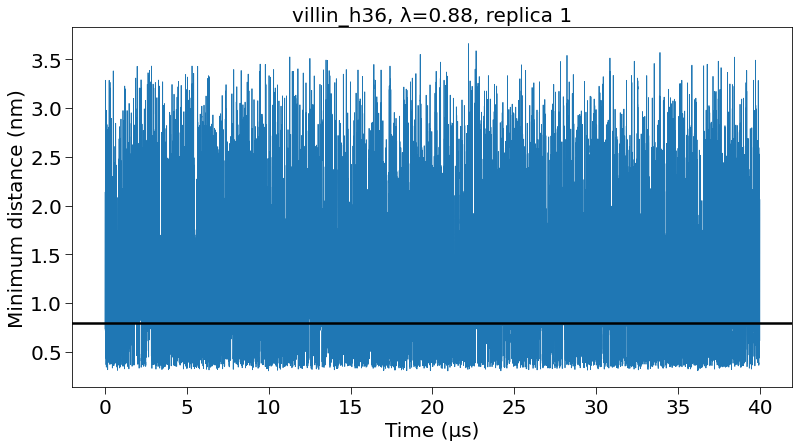

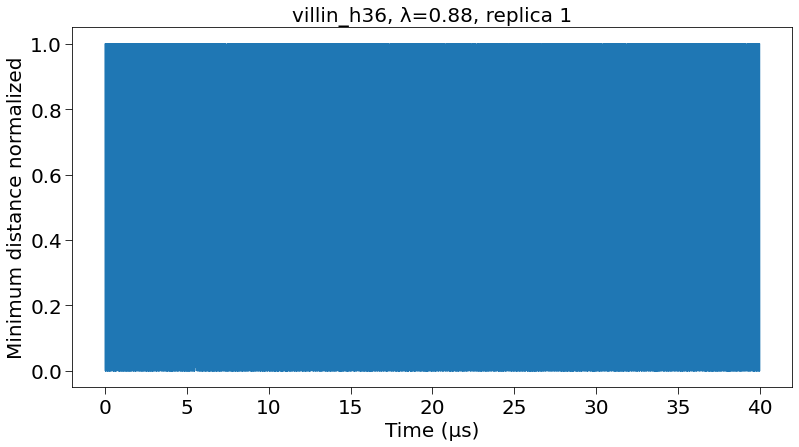

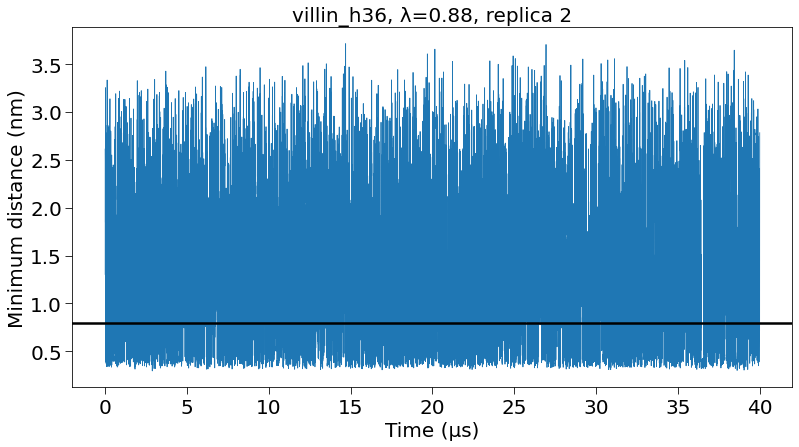

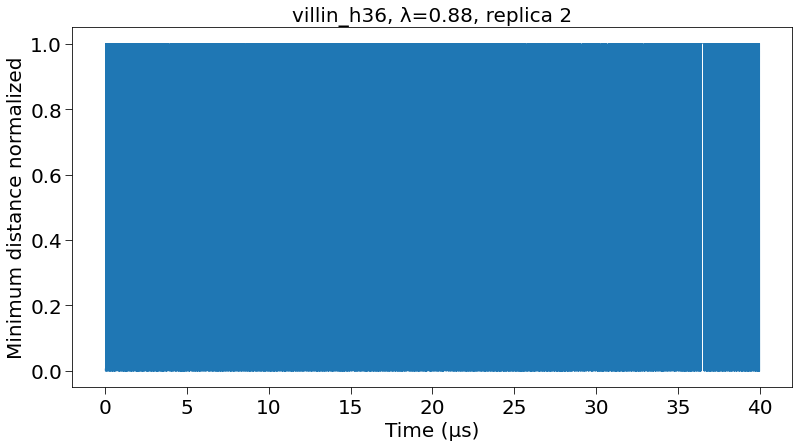

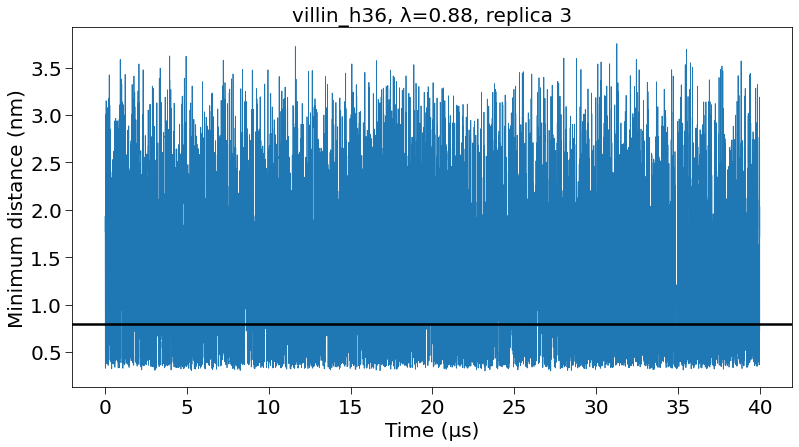

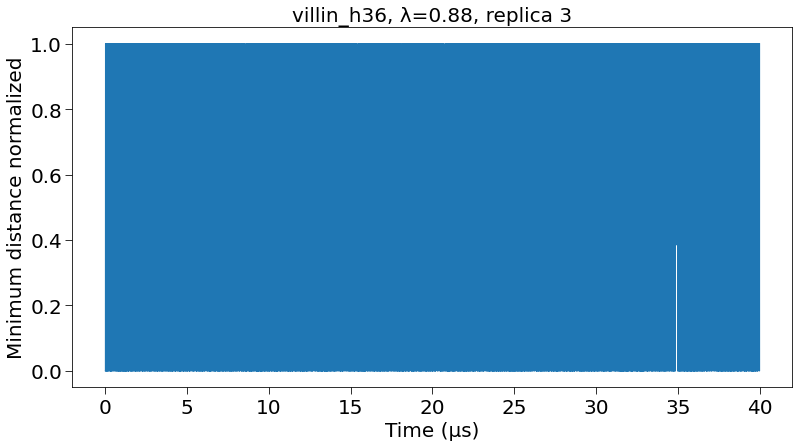

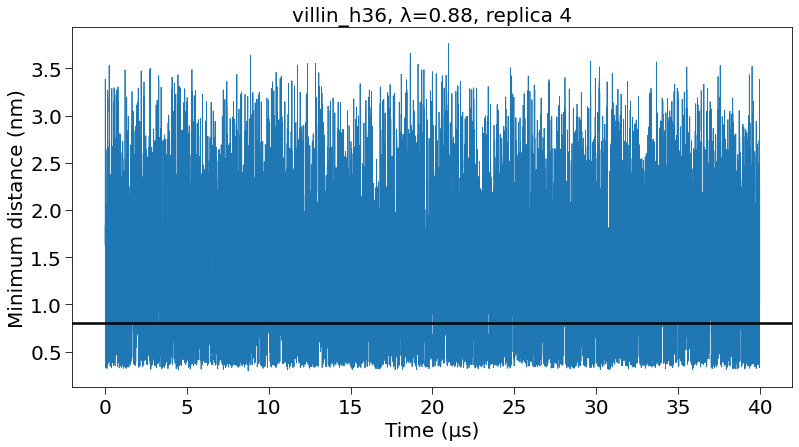

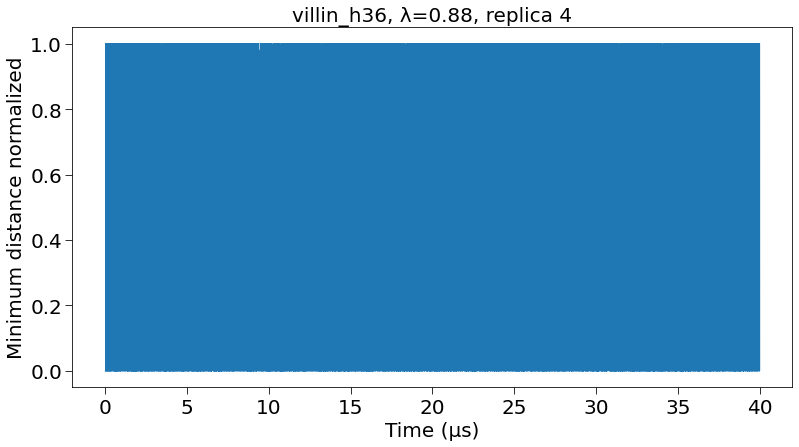

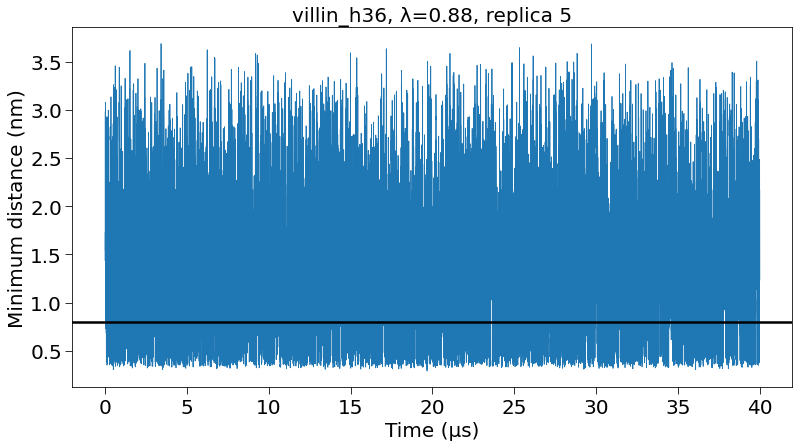

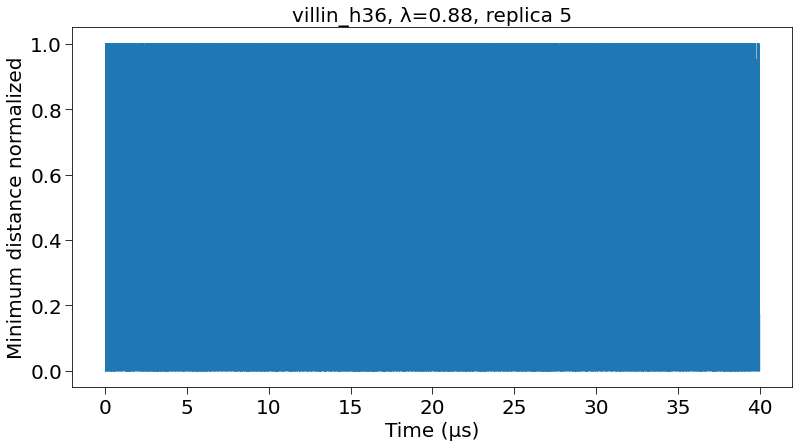

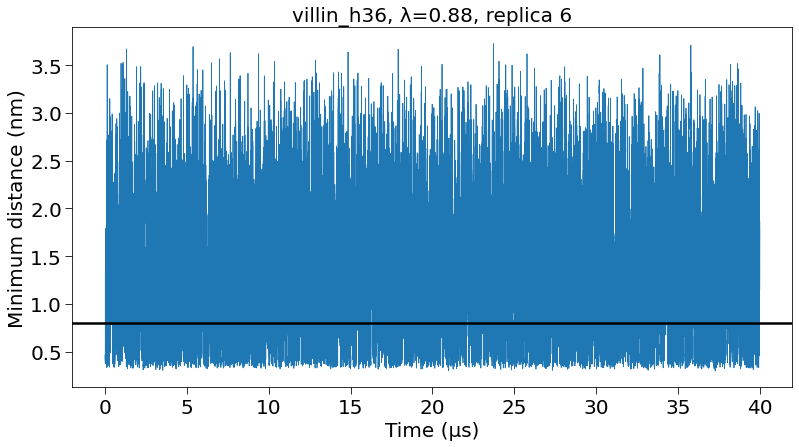

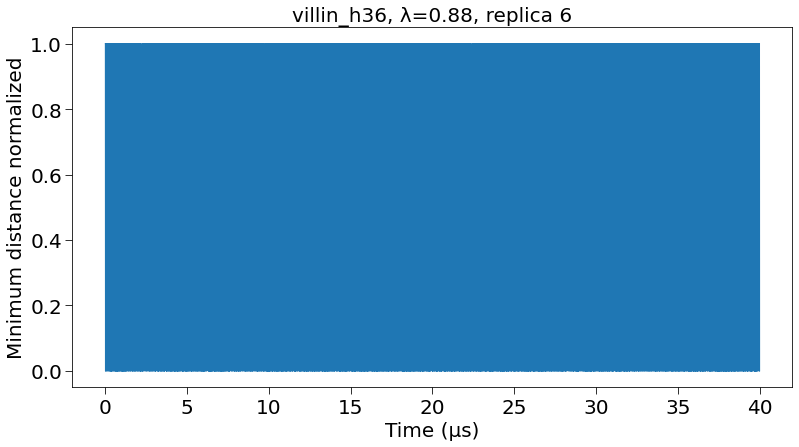

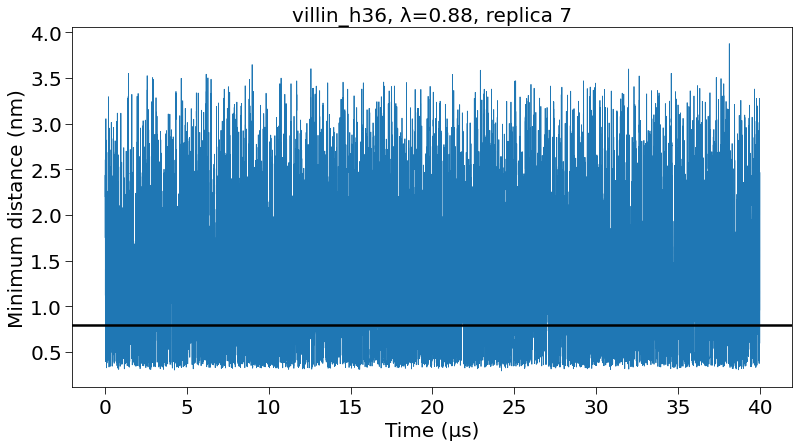

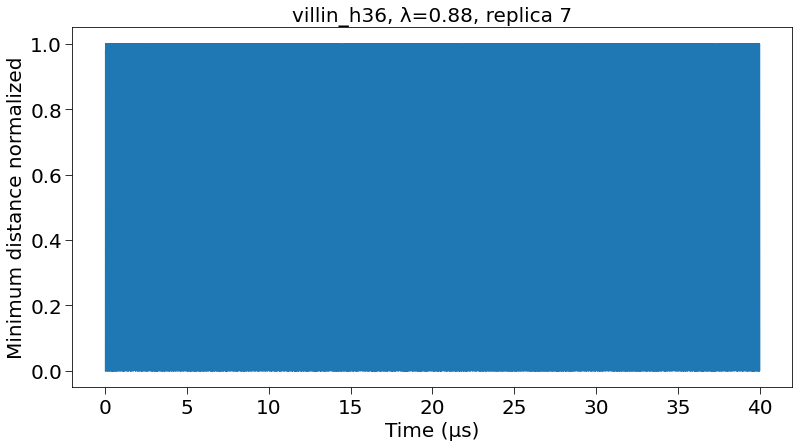

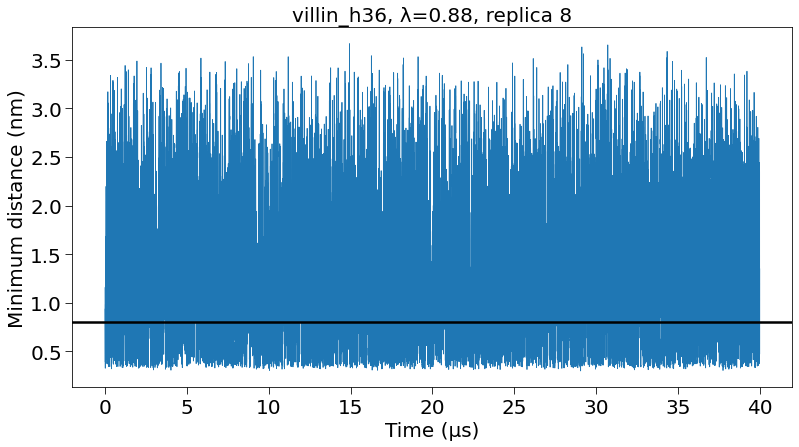

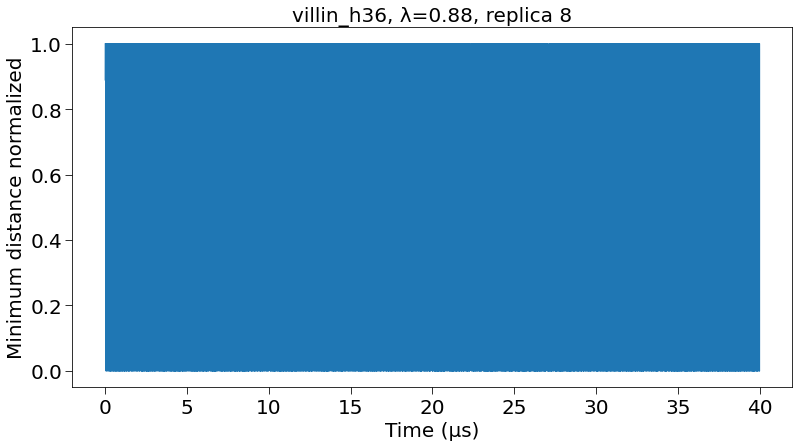

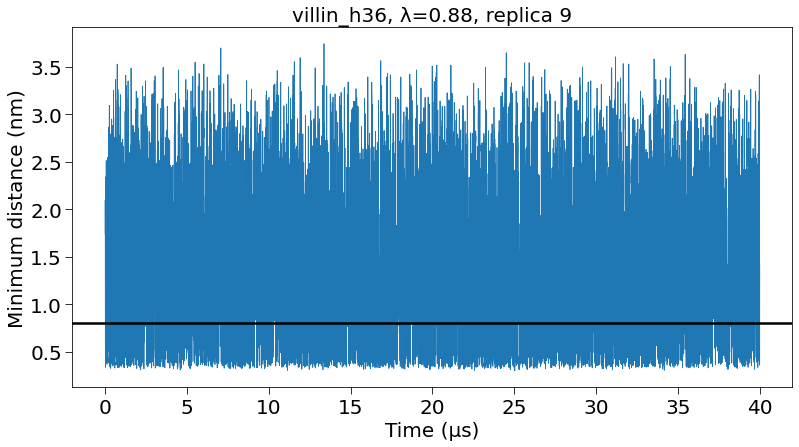

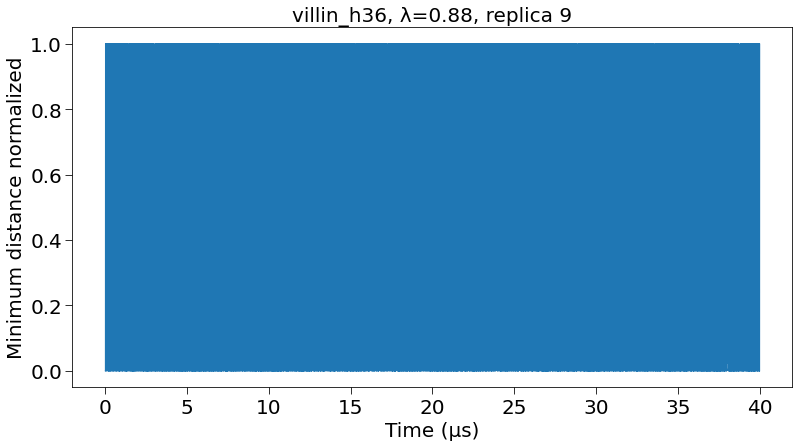

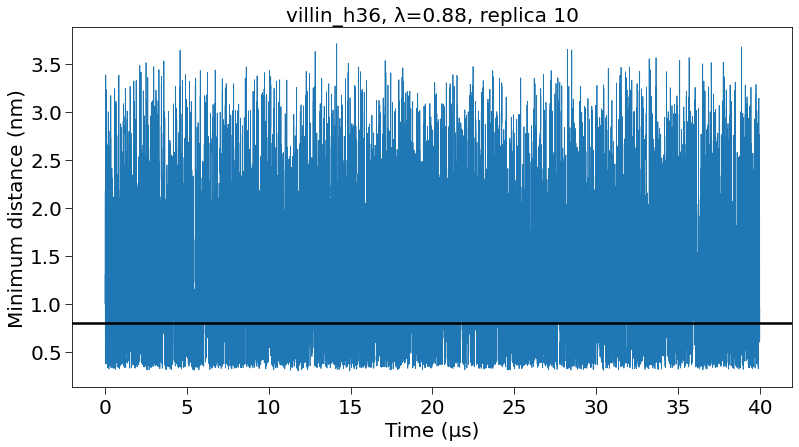

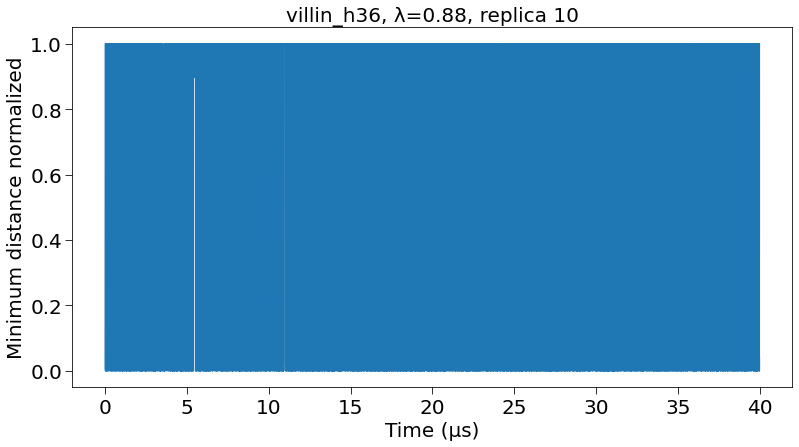

In [5]:
fraction_bound_vs_replica_vs_lambda_vs_protein = []
fraction_bound_vs_lambda_vs_protein = []
fraction_bound_err_vs_lambda_vs_protein = []

for protein in proteins:
    #Analyze fraction bound and unbound with single cut-off
    fraction_bound_vs_replica_vs_lambda = []
    fraction_bound_vs_lambda = []
    fraction_bound_err_vs_lambda = []
    
    os.system(f'mkdir figures/{protein}')
    
    #Loop over rescaling approaches
    for approach in rescaling_approach:
        l=lambdas_approach[approach]

        fraction_bound_vs_replica = []

        for replica in range(1,replicas+1): 

            #Load data
            if approach == 'PW' or approach == 'OG':
                time, mindist = np.genfromtxt(f'{PW_dir}/{protein}/two_{protein}_{replica}/lambda_{l}/data/{protein}1_{protein}2_mindist_lambda{l}.xvg', skip_header=24, usecols=(0,1), unpack=True)
            elif approach == 'PP':
                time, mindist = np.genfromtxt(f'{protein}/data/{protein}1_{protein}2_mindist_rep{replica}.xvg', skip_header=24, usecols=(0,1), unpack=True)

            #Plot data initially
            fig= plt.figure(figsize=(10,5))
            axes= fig.add_axes([1,1,1,1])

            plt.plot(time, mindist, '-', linewidth = 0.8)

            plt.axhline(thresh, linewidth=2.5, color='black', alpha=1)

            plt.title(f'{protein}, λ={l}, replica {replica}', fontsize=20)

            plt.tick_params(colors='black', direction='out', length=7, labelsize=20)

            plt.ylabel('Minimum distance (nm)', fontsize=20)
            plt.xlabel('Time (µs)', fontsize=20)
            
            #fig.savefig(f"figures/{protein}/mindist_vs_time_{approach}_replica{replica}.png", bbox_inches='tight', pad_inches=1, dpi=400)
            #fig.savefig(f"figures/{protein}/mindist_vs_time_{approach}_replica{replica}.pdf", bbox_inches='tight', pad_inches=1, dpi=400)

            #Fermi transform to check for two states
            L=1.5
            B=50

            mindist_fermi = 1/(1+np.exp(B*(mindist-L*thresh)))

            #Plot data fermi transformed for first 20us
            fig= plt.figure(figsize=(10,5))
            axes= fig.add_axes([1,1,1,1])

            plt.plot(time, mindist_fermi, '-', linewidth = 0.8)

            plt.title(f'{protein}, λ={l}, replica {replica}', fontsize=20)

            plt.tick_params(colors='black', direction='out', length=7, labelsize=20)

            plt.ylabel('Minimum distance normalized', fontsize=20)
            plt.xlabel('Time (µs)', fontsize=20)

            #fig.savefig(f"figures/{protein}/mindist_vs_time_fermiswitch_{approach}_replica{replica}.png", bbox_inches='tight', pad_inches=1, dpi=400)
            #fig.savefig(f"figures/{protein}/mindist_vs_time_fermiswitch_{approach}_replica{replica}.pdf", bbox_inches='tight', pad_inches=1, dpi=400)

            #Count number of bound
            frames_bound = np.count_nonzero(mindist < thresh)
            #Get fraction bound
            fraction_bound = frames_bound/len(mindist)
            #Append to list
            fraction_bound_vs_replica.append(fraction_bound)

        #Average over replicas
        fraction_bound_vs_replica_vs_lambda.append(fraction_bound_vs_replica)
        fraction_bound_avg = np.average(fraction_bound_vs_replica)
        fraction_bound_vs_lambda.append(fraction_bound_avg)

        #Get standard deviation over replicas
        fraction_bound_err = np.std(fraction_bound_vs_replica)/np.sqrt(np.size(fraction_bound_vs_replica))
        fraction_bound_err_vs_lambda.append(fraction_bound_err)

    fraction_bound_vs_replica_vs_lambda_vs_protein.append(fraction_bound_vs_replica_vs_lambda)
    fraction_bound_vs_lambda_vs_protein.append(fraction_bound_vs_lambda)
    fraction_bound_err_vs_lambda_vs_protein.append(fraction_bound_err_vs_lambda)

[0.7120121996950076, 0.2682782930426739, 0.26399090022749433]
[0.006751801102713388, 0.002414947907861603, 0.0016025455424992178]
[0.7120121996950076, 0.2682782930426739, 0.26399090022749433]
[0.006751801102713388, 0.002414947907861603, 0.0016025455424992178]


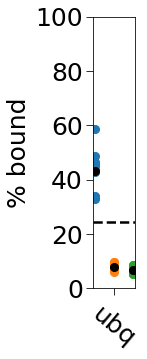

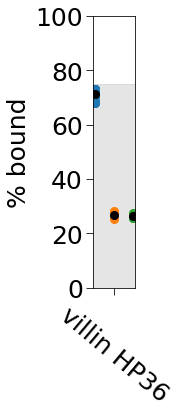

In [6]:
for i,protein in enumerate(proteins):
    
    #Plot data
    fig= plt.figure(figsize=(0.75,5))

    for j,l in enumerate(rescaling_approach):
        plt.plot([j]*replicas, np.array(fraction_bound_vs_replica_vs_lambda_vs_protein[i][j])*100, 'o', markersize=8, c=colors[j])
        plt.plot(j, np.array(fraction_bound_vs_lambda_vs_protein[i][j])*100, 'o', markersize=8, color='black')
    
    if protein != 'villin_h36':
        plt.axhline(np.array(real_fraction_bound_vs_protein[i])*100, linewidth=2.5, color='black', linestyle="--")
    
    plt.ylim(0,100)
    
    plt.ylabel('% bound', fontsize=25)
    plt.xlabel(protein, fontsize=25, rotation=-40)
    
    plt.xticks([1], '')

    if protein=='villin_h36':
        plt.xlabel('villin HP36', fontsize=25, rotation=-40)
    else:
        plt.xlabel(protein, fontsize=25, rotation=-40)
        
    plt.tick_params(colors='black', direction='out', length=7, labelsize=25)
    plt.tick_params(colors='black', axis='x', direction='out', rotation=-40, length=7, labelsize=25)
    
    xlim1 = plt.xlim()[0]
    xlim2 = plt.xlim()[1]

    if protein=='villin_h36':
        plt.fill_between([xlim1-100,xlim2+100], plt.ylim()[0], np.array(real_fraction_bound_vs_protein[i])*100, color='black', alpha=0.1)

    plt.xlim(xlim1, xlim2)
    
    fig.savefig(f"figures/{protein}/fractionbound_vs_lambda.png", bbox_inches='tight', pad_inches=1, dpi=400)
    fig.savefig(f"figures/{protein}/fractionbound_vs_lambda.pdf", bbox_inches='tight', pad_inches=1, dpi=400)

    print(fraction_bound_vs_lambda)
    print(fraction_bound_err_vs_lambda)

[0.7120121996950076, 0.2682782930426739, 0.26399090022749433]
[0.006751801102713388, 0.002414947907861603, 0.0016025455424992178]
[0.7120121996950076, 0.2682782930426739, 0.26399090022749433]
[0.006751801102713388, 0.002414947907861603, 0.0016025455424992178]


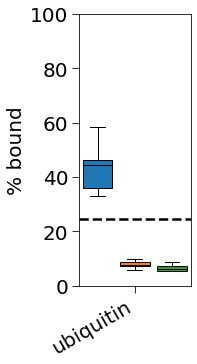

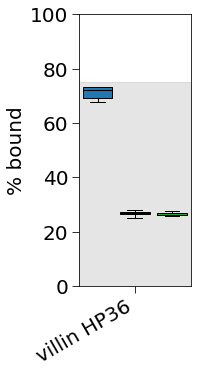

In [9]:
for i,protein in enumerate(proteins):
    
    #Plot data
    fig= plt.figure(figsize=(2,5))

    for j,l in enumerate(rescaling_approach):
        plt.boxplot(np.array(fraction_bound_vs_replica_vs_lambda_vs_protein[i][j])*100, vert=True, patch_artist=True, positions=[j], widths=[0.8],
            boxprops=dict(facecolor=colors[j], color='black'),
            capprops=dict(color='black'),
            whiskerprops=dict(color='black'),
            flierprops=dict(color='black', markeredgecolor='black'),
            medianprops=dict(color='black'),
            )
        
        #plt.plot([j]*replicas, np.array(fraction_bound_vs_replica_vs_lambda_vs_protein[i][j])*100, 'o', markersize=5, c=colors[j])
        #plt.violinplot(np.array(fraction_bound_vs_replica_vs_lambda_vs_protein[i][j])*100, positions=[j], vert=True, widths=1)

    if protein != 'villin_h36':
        plt.axhline(np.array(real_fraction_bound_vs_protein[i])*100, linewidth=2.5, color='black', linestyle="--")
    
    plt.ylim(0,100)
    
    plt.ylabel('% bound', fontsize=20)
        
    plt.tick_params(colors='black', direction='out', length=7, labelsize=20)
    plt.xticks([1], labels=[protein_names[protein]], rotation=30, fontsize=20, ha='right')

    xlim1 = plt.xlim()[0]
    xlim2 = plt.xlim()[1]

    if protein=='villin_h36':
        plt.fill_between([xlim1-100,xlim2+100], plt.ylim()[0], np.array(real_fraction_bound_vs_protein[i])*100, color='black', alpha=0.1)

    plt.xlim(xlim1, xlim2)
    
    fig.savefig(f"figures/{protein}/fractionbound_vs_lambda.png", bbox_inches='tight', pad_inches=1, dpi=400)
    fig.savefig(f"figures/{protein}/fractionbound_vs_lambda.pdf", bbox_inches='tight', pad_inches=1, dpi=400)

    print(fraction_bound_vs_lambda)
    print(fraction_bound_err_vs_lambda)